In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as pl
from mpl_toolkits.mplot3d.axes3d import Axes3D
from PIL import Image
import f_class
from GP import GP
from GP_grad import GP_grad
import time
import imageio

In [2]:
Noise = False # Specify if noisy or not
Noise_level = 0.00 # if noisy, what is the noise sd
'''If use the scaled X and y, rememeber to scale the noise as well'''

'If use the scaled X and y, rememeber to scale the noise as well'

In [3]:
objective = f_class.sin(Noise, Noise_level)
objective = f_class.Ackley_1(Noise, Noise_level)
# objective = f_class.Schwefel(Noise, Noise_level, 1)

clean_f = lambda x: f_class.sin().func(x)
clean_f = lambda x: f_class.Ackley_1().func(x)
# clean_f = lambda x: f_class.Schwefel(dim=1).func(x)

B = np.array([item[1] for item in sorted(objective.bounds.items(), key=lambda x: x[0])], dtype=np.float64)
lb = B[:, 0]; ub = B[:, 1]

f = objective.func
print(f( np.array([2]) ))

dim = objective.input_dim
print('dim: ', dim)

[[0.65935991]]
dim:  1


In [4]:
# max budget for finding good point
Budget = 100

In [5]:
# set seed
seed = 1
def draw(n_random_draws=3):
    X = np.random.uniform(lb, ub, size=(n_random_draws, dim))
    return X, f(X)

def optimize_hyper(lb, ub, sample_size=200):
    
    ls, var = gp.optimize()
    gp.clear()
    return (ls, var)

In [6]:
# # find optimized hyper
# gp = GP_grad(B, Noise, Noise_level, compress=True)

# X = np.asarray(np.random.uniform(lb, ub, size=(1000, dim)))
# gp.set_data(X, f(X))

# (ls, var) = gp.optimize()
# del gp
# (ls, var)

In [24]:
gp = GP_grad(B, Noise, Noise_level, compress=True)

# set optimized hyper
# gp.set_hyper(ls, var)

# put in some random data (let them to be close)
init_size = 3
# X = np.asarray(np.random.uniform(lb, ub, size=(init_size, dim)))
X = np.random.uniform(lb, ub, size=(init_size, dim))

gp.set_data(X, f(X))
gp.optimize()
gp.fit()

array([[ 1.78054394],
       [-1.85594286],
       [-0.4833815 ]])

In [25]:
gp._y, gp.posterior(X)

(array([[ 0.        ],
        [-1.76842519],
        [ 0.58361037]]),
 (array([[-1.79834938e-06],
         [-1.76842331e+00],
         [ 5.83610863e-01]]),
  array([[ 1.00998996e-06,  3.53406193e-12,  7.59614593e-12],
         [ 3.53406193e-12,  1.00999815e-06, -2.37654341e-12],
         [ 7.59614593e-12, -2.37654341e-12,  1.00999364e-06]])))

In [26]:
# Grid -> test points for plotting
n_Grid = 500
Grid = np.linspace(lb, ub, n_Grid).reshape(-1, dim)

In [27]:
mu, covar = gp.posterior(Grid)
mu = np.squeeze(mu)
s = np.sqrt(np.diag(covar))

CubeGrid = gp.compress(Grid)
Kt = gp.cov_RBF(CubeGrid, CubeGrid, gp.get_hyper())
K_11 = gp.K11(CubeGrid)
K_01 = gp.K01(CubeGrid)

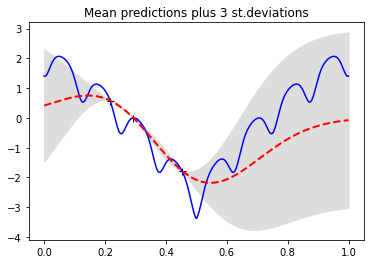

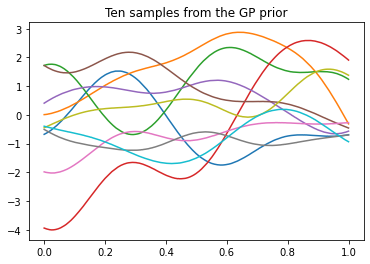

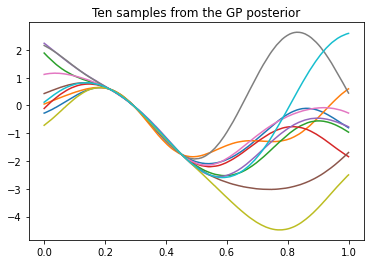

In [28]:
# plot
pl.figure(1)
pl.clf()
pl.plot(gp._X, gp._y, 'k+', ms=7)
pl.plot(CubeGrid, gp._normal(clean_f(Grid)), 'b-')
pl.gca().fill_between(CubeGrid.flat, mu-2*s, mu+2*s, color="#dddddd")

pl.plot(CubeGrid, mu, 'r--', lw=2)
# pl.savefig('predictive.png', bbox_inches='tight')
pl.title('Mean predictions plus 3 st.deviations')

# draw samples from the prior at our test points.
L = np.linalg.cholesky(Kt + 1e-6*np.eye(n_Grid))
f_prior = np.dot(L, np.random.normal(size=(n_Grid, 10)))
pl.figure(2)
pl.clf()
pl.plot(CubeGrid, f_prior)
pl.title('Ten samples from the GP prior')
# pl.savefig('prior.png', bbox_inches='tight')

# draw samples from the posterior at our test points.
L = np.linalg.cholesky(covar + 1e-6*np.eye(n_Grid)) # LL^T = Sigma (posterior covariance)
f_post = mu.reshape(-1,1) + np.dot(L, np.random.normal(size=(n_Grid, 10)))
pl.figure(3)
pl.clf()
pl.plot(CubeGrid, f_post)
pl.title('Ten samples from the GP posterior')
# pl.savefig('post.png', bbox_inches='tight')

pl.show()

In [29]:
mu_grad, covar_grad = gp.posterior_grad(Grid)
s_grad = np.sqrt(np.diag(covar_grad))
mu_grad = np.squeeze(mu_grad)

In [30]:
from scipy import optimize

# optimize.approx_fprime(x, clean_Ackley_1d, eps)
eps = np.sqrt(np.finfo(float).eps)
approx_grad = [optimize.approx_fprime(x, lambda x: clean_f(x).item(), eps) for x in Grid]

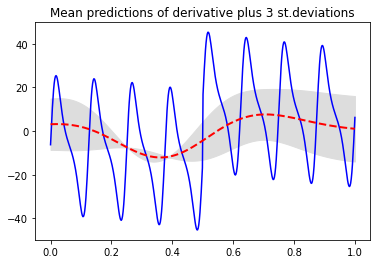

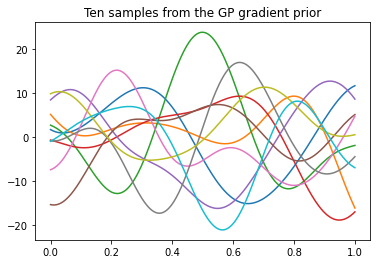

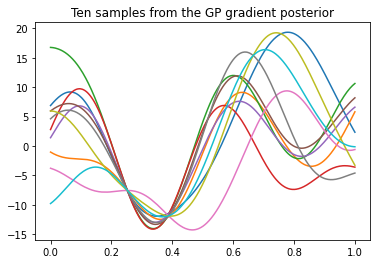

In [31]:
# plot
pl.figure(1)
pl.clf()
# pl.plot(X, y, 'r+', ms=7)
pl.plot(CubeGrid, gp._normal_grad(approx_grad), 'b-')
pl.gca().fill_between(CubeGrid.flat, mu_grad-2*s_grad, mu_grad+2*s_grad, color="#dddddd")

pl.plot(CubeGrid, mu_grad, 'r--', lw=2)
pl.savefig('predictive_grad.png', bbox_inches='tight')
pl.title('Mean predictions of derivative plus 3 st.deviations')

# draw samples from the prior at our test points.
L = np.linalg.cholesky(K_11 + 1e-6*np.eye(n_Grid))
f_prior = np.dot(L, np.random.normal(size=(n_Grid, 10)))
pl.figure(2)
pl.clf()
pl.plot(CubeGrid, f_prior)
pl.title('Ten samples from the GP gradient prior')
pl.savefig('prior_grad.png', bbox_inches='tight')

# draw samples from the posterior at our test points.
L = np.linalg.cholesky(covar_grad + 1e-6*np.eye(n_Grid)) # LL^T = Sigma (posterior covariance)
f_post = mu_grad.reshape(-1,1) + np.dot(L, np.random.normal(size=(n_Grid, 10)))
pl.figure(3)
pl.clf()
pl.plot(CubeGrid, f_post)
pl.title('Ten samples from the GP gradient posterior')
pl.savefig('post_grad.png', bbox_inches='tight')

pl.show()

### Gradient Descent 

In [32]:
n_iter = 40
lr = 0.001
lr_init = 15
alpha = 0.5

history = []
history_lr = []


w = X[0].reshape(1, -1) 
# arg_min = np.argmin(f(X))
# w = X[arg_min].reshape(1, -1) # min value to start
w

array([[-1.65750339]])

In [33]:
gp.posterior_grad(w), gp._normal_grad(optimize.approx_fprime(np.squeeze(w), lambda x: clean_f(x).item(), eps))

((array([[-10.12428095]]), array([[0.92735414]])), array([0.56147497]))

In [34]:
# for Adam
epsilon = 1e-8
b1 = 0.9
b2 = 0.999
lr = 0.01
mt = np.array([0])
vt = np.array([0])

In [35]:
gp.X

array([[-1.65750339],
       [-0.38240429],
       [-2.26909902]])

`Backtrack`
$$F(x_n + \eta \times d_n) < F(x_n) + \alpha \times \eta \times \langle d_n, \nabla F(x_n)\rangle$$

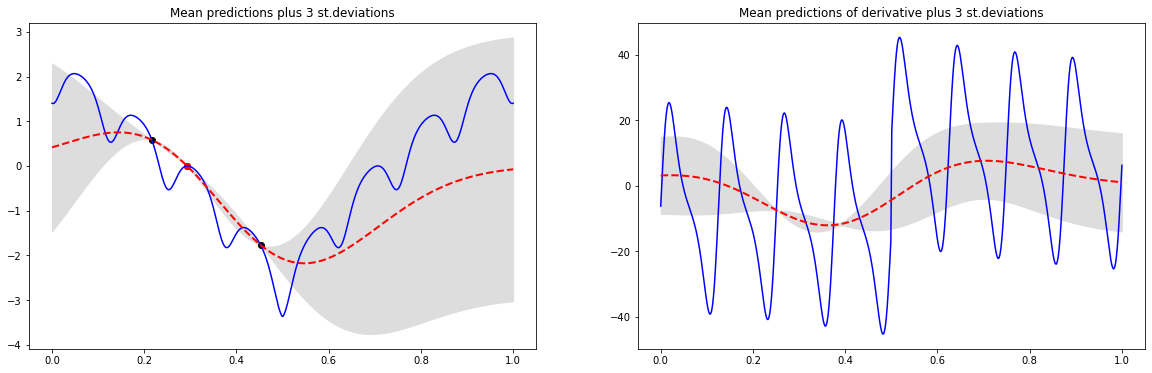

w:  [[0.29390381]]
lr:  [[0.00010783]]
df: [[-10.1829328]], s.d. [[0.95661851]]
actual df [-0.29822598]
  # Optimal (ls, var) =  (0.06606550759192983, 1.4074789504759266)


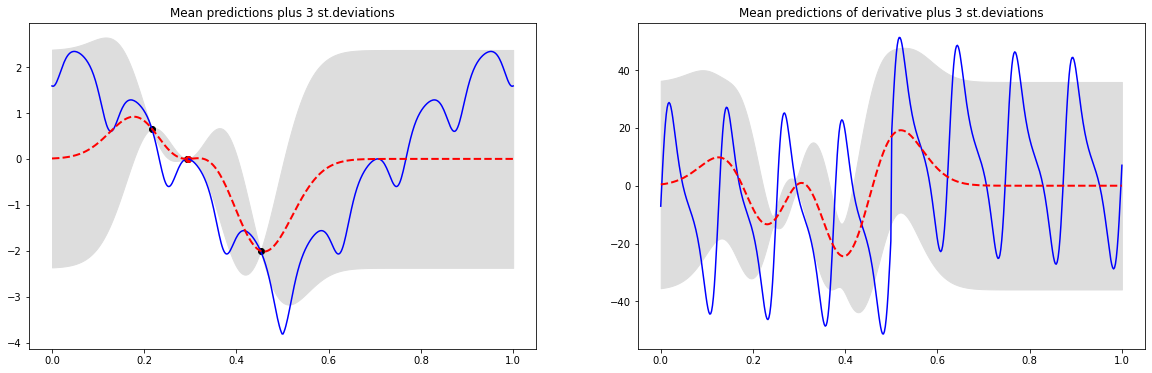

w:  [[0.29389733]]
lr:  [[5.80977097e-05]]
df: [[0.11061167]], s.d. [[1.72053201]]
actual df [-0.3321929]


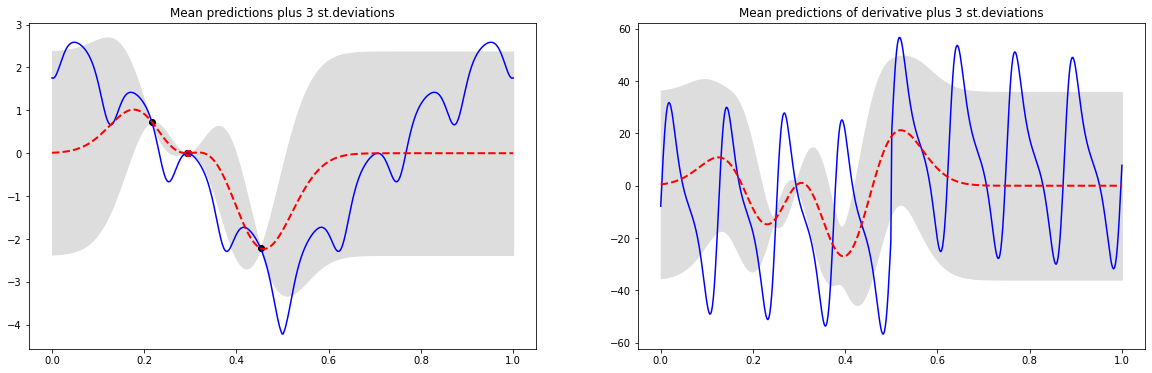

w:  [[0.29388543]]
lr:  [[7.66030689e-05]]
df: [[0.15342642]], s.d. [[1.30428234]]
actual df [-0.35582927]


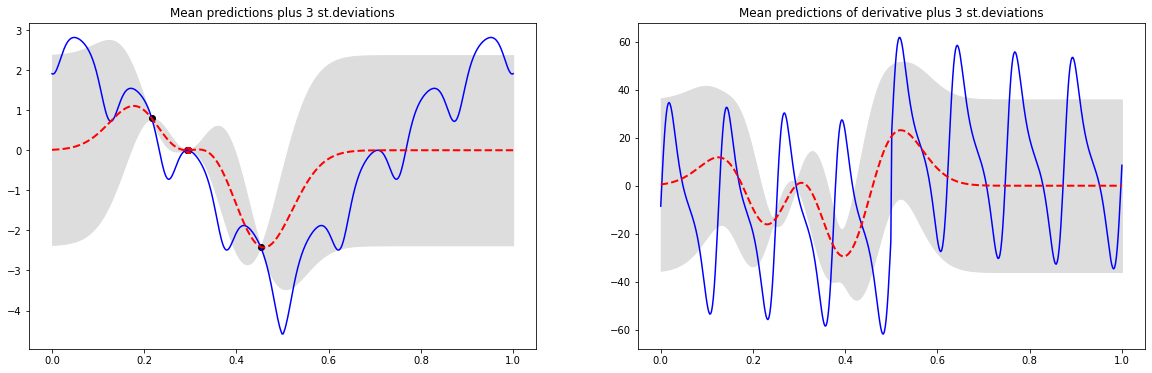

w:  [[0.29387003]]
lr:  [[8.52697482e-05]]
df: [[0.17789496]], s.d. [[1.17133881]]
actual df [-0.37082615]


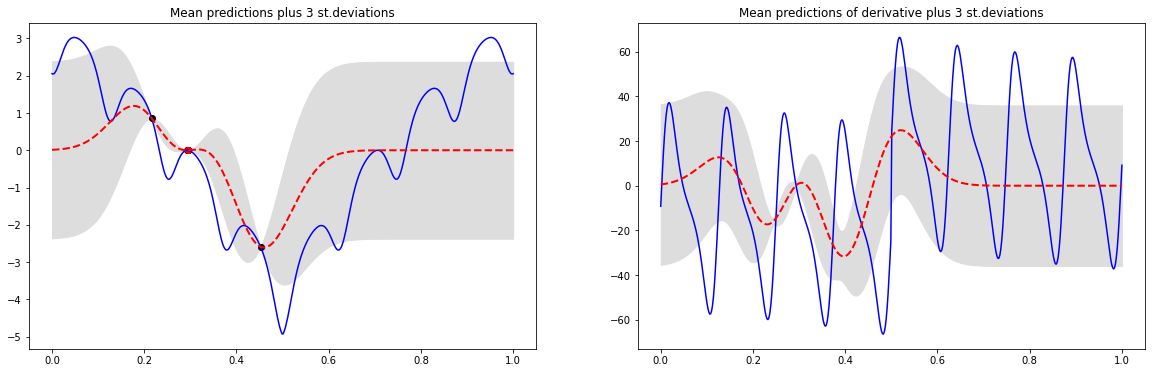

w:  [[0.29385203]]
lr:  [[8.99263431e-05]]
df: [[0.19678831]], s.d. [[1.11043061]]
actual df [-0.37819987]


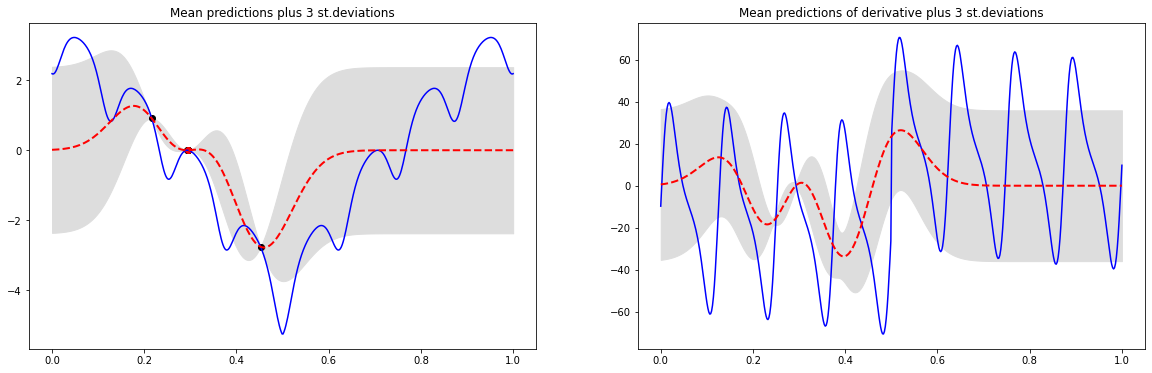

w:  [[0.29383197]]
lr:  [[9.25508161e-05]]
df: [[0.21261626]], s.d. [[1.07876854]]
actual df [-0.37868861]
  # Optimal (ls, var) =  (0.10092789622361588, 15.298464515082431)


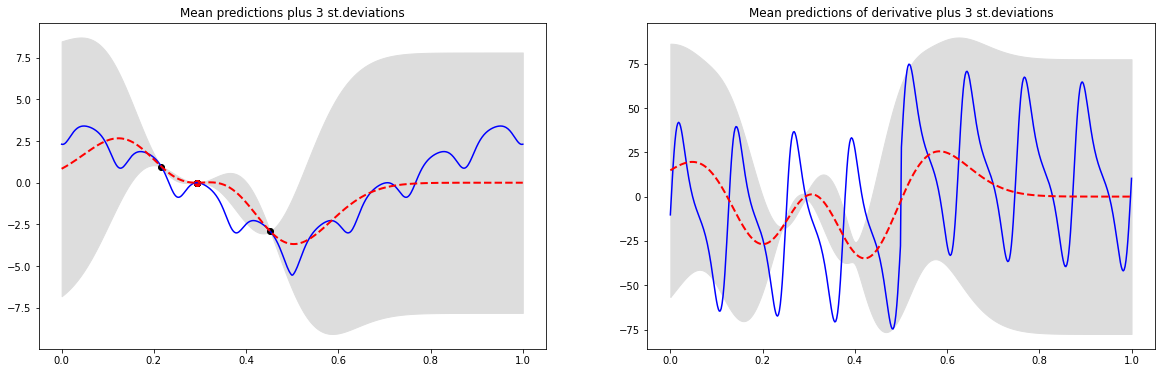

w:  [[0.29381022]]
lr:  [[9.41808715e-05]]
df: [[0.22744526]], s.d. [[1.06041084]]
actual df [-0.37283262]


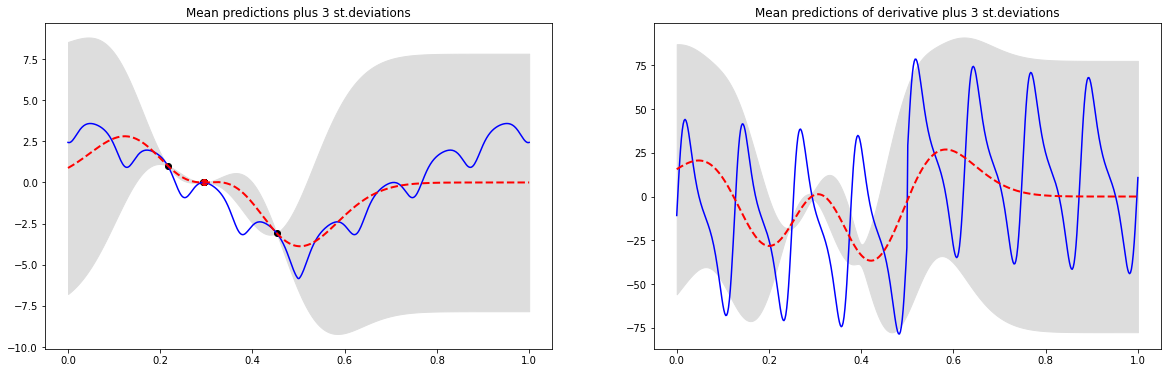

w:  [[0.2937871]]
lr:  [[9.49471083e-05]]
df: [[0.23970266]], s.d. [[1.05178886]]
actual df [-0.36113026]


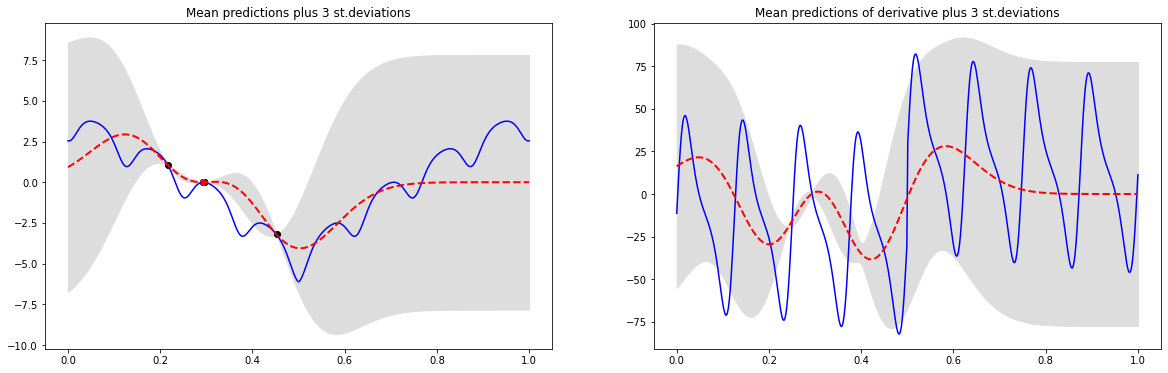

w:  [[0.29376288]]
lr:  [[9.53177125e-05]]
df: [[0.24984314]], s.d. [[1.04766149]]
actual df [-0.34406888]


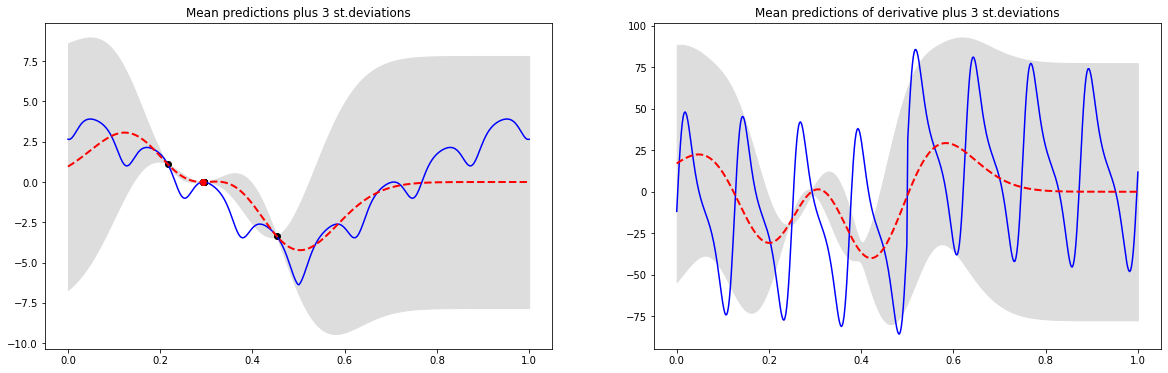

w:  [[0.29373784]]
lr:  [[9.54954387e-05]]
df: [[0.25753361]], s.d. [[1.04569756]]
actual df [-0.32215381]


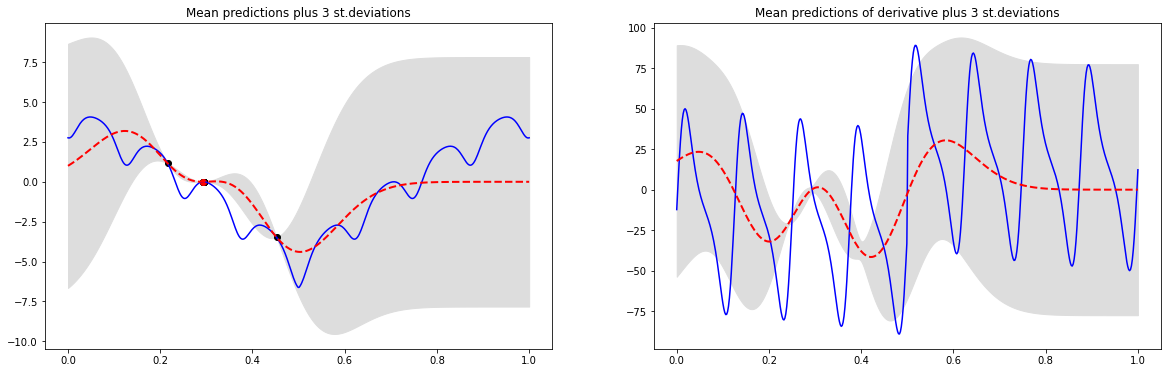

w:  [[0.29371228]]
lr:  [[9.5632036e-05]]
df: [[0.26240606]], s.d. [[1.04421157]]
actual df [-0.29592225]
  # Optimal (ls, var) =  (0.06586144766974297, 4.560964304576168)


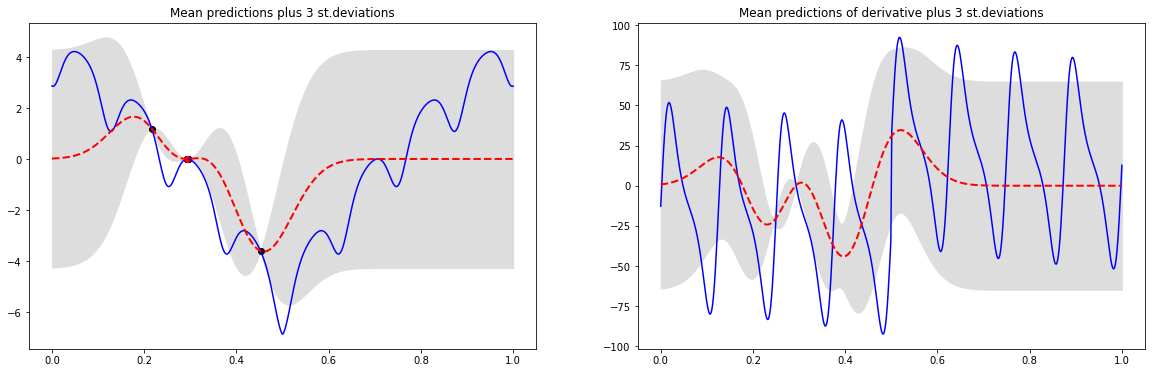

w:  [[0.29367942]]
lr:  [[9.39079599e-05]]
df: [[0.34114844]], s.d. [[1.05963106]]
actual df [-0.25477903]


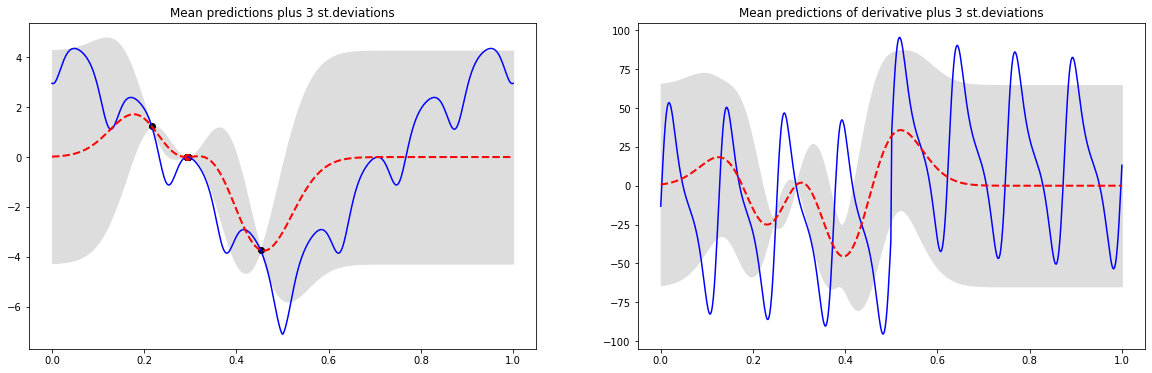

w:  [[0.29364668]]
lr:  [[9.47265961e-05]]
df: [[0.3365934]], s.d. [[1.05089161]]
actual df [-0.20984986]


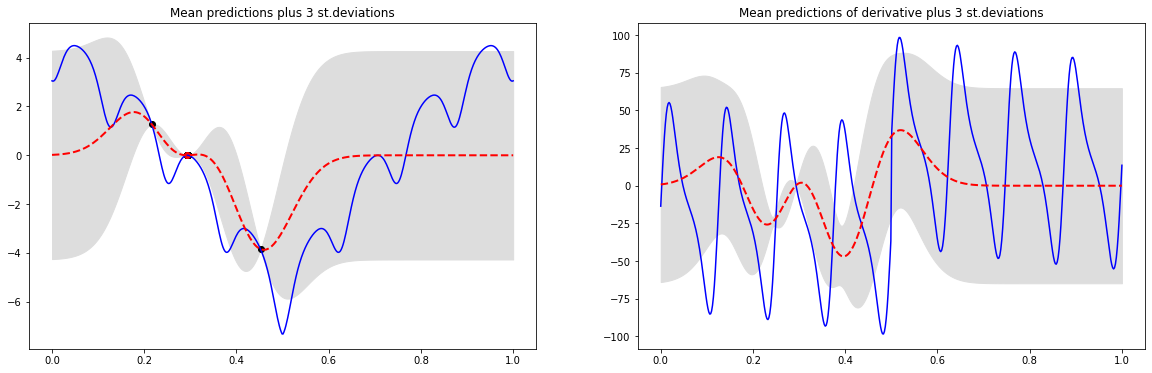

w:  [[0.29361446]]
lr:  [[9.59040129e-05]]
df: [[0.3267574]], s.d. [[1.03846822]]
actual df [-0.16203092]


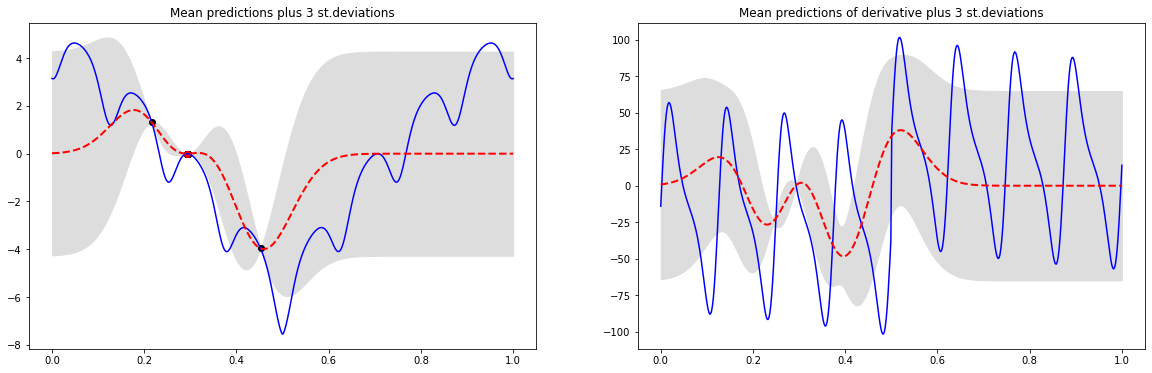

w:  [[0.29358316]]
lr:  [[9.75359705e-05]]
df: [[0.31177466]], s.d. [[1.02160729]]
actual df [-0.11226353]


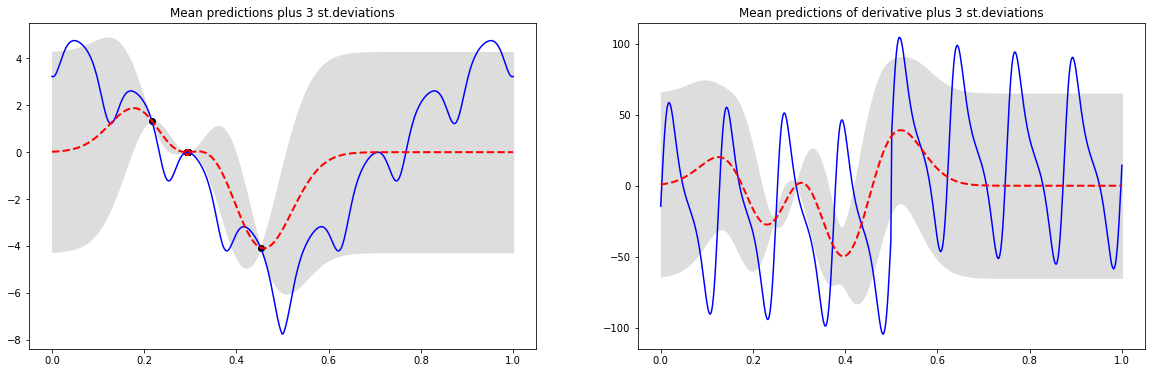

w:  [[0.29355314]]
lr:  [[9.96883987e-05]]
df: [[0.29219673]], s.d. [[1.0000751]]
actual df [-0.06148203]
  # Optimal (ls, var) =  (0.09299843523521152, 22.890319685465716)


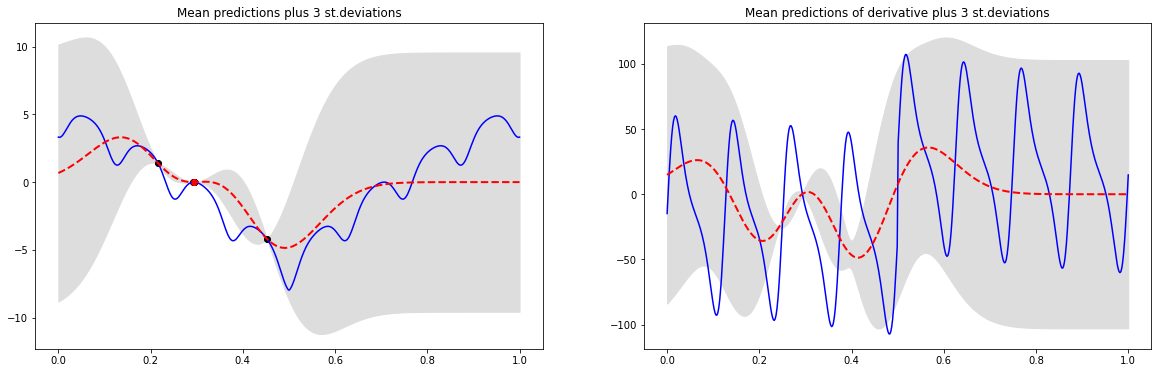

w:  [[0.29352628]]
lr:  [[0.00010263]]
df: [[0.2554612]], s.d. [[0.97280767]]
actual df [-0.01349813]


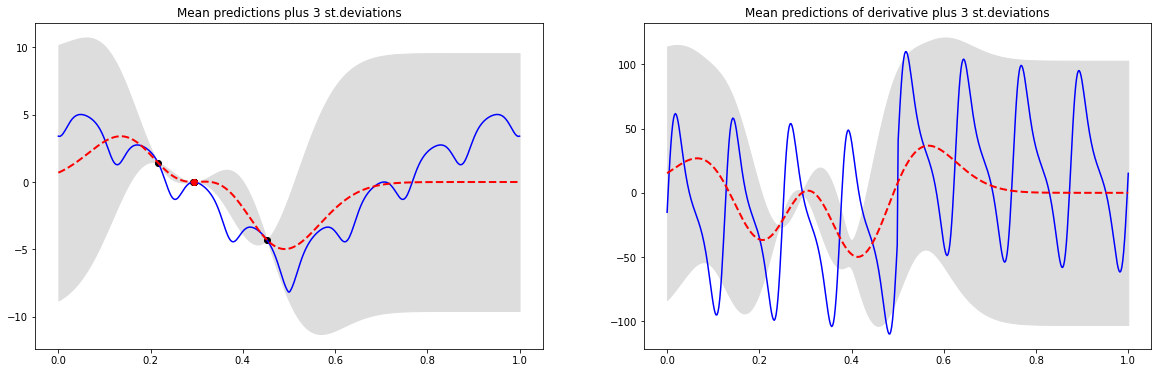

w:  [[0.29350102]]
lr:  [[0.00010574]]
df: [[0.23285138]], s.d. [[0.94442863]]
actual df [0.03406912]


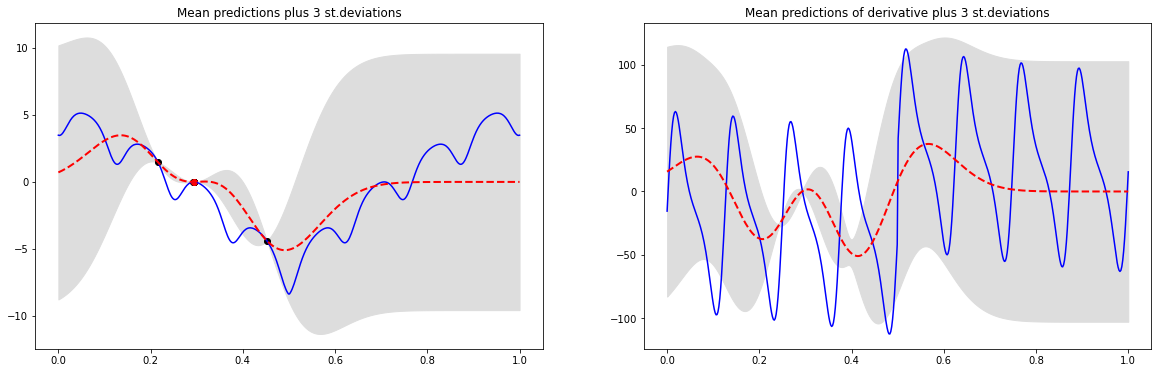

w:  [[0.29347755]]
lr:  [[0.00010937]]
df: [[0.20893116]], s.d. [[0.9132778]]
actual df [0.08055179]


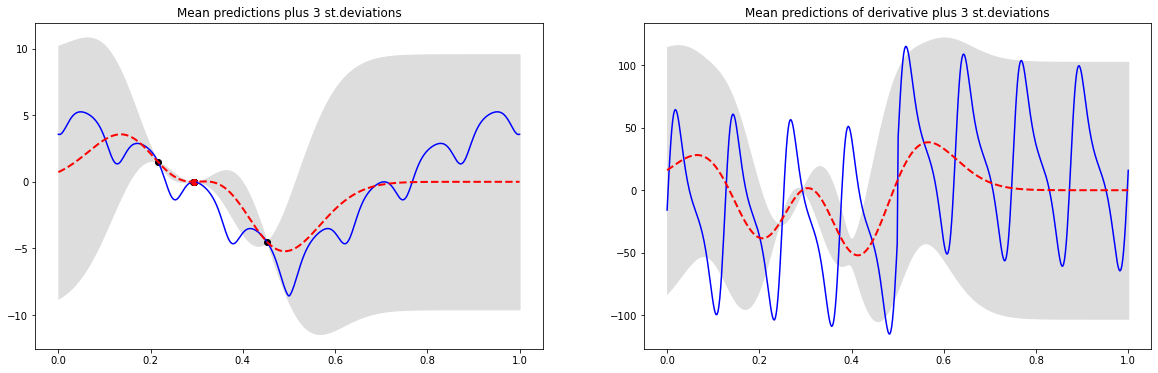

w:  [[0.29345598]]
lr:  [[0.00011349]]
df: [[0.18466101]], s.d. [[0.88031586]]
actual df [0.1253645]


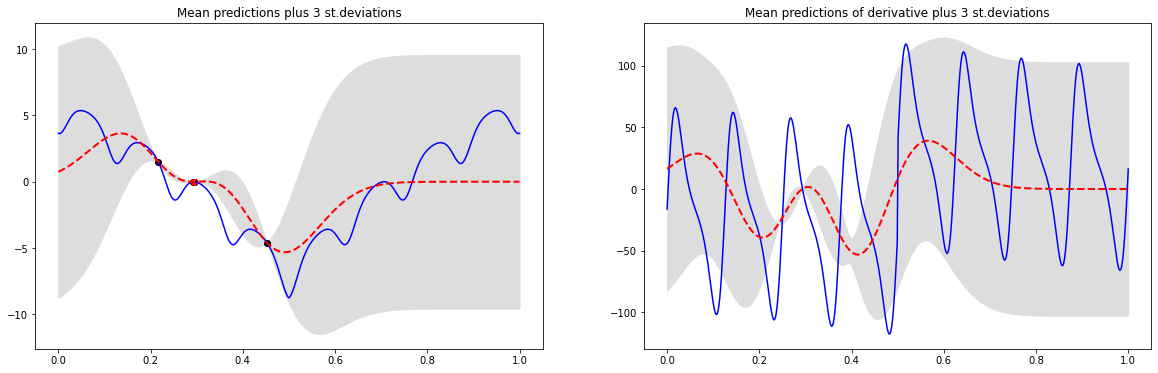

w:  [[0.29343641]]
lr:  [[0.00011805]]
df: [[0.16086692]], s.d. [[0.84649914]]
actual df [0.1680166]
  # Optimal (ls, var) =  (0.08751102482664834, 22.519648861923827)


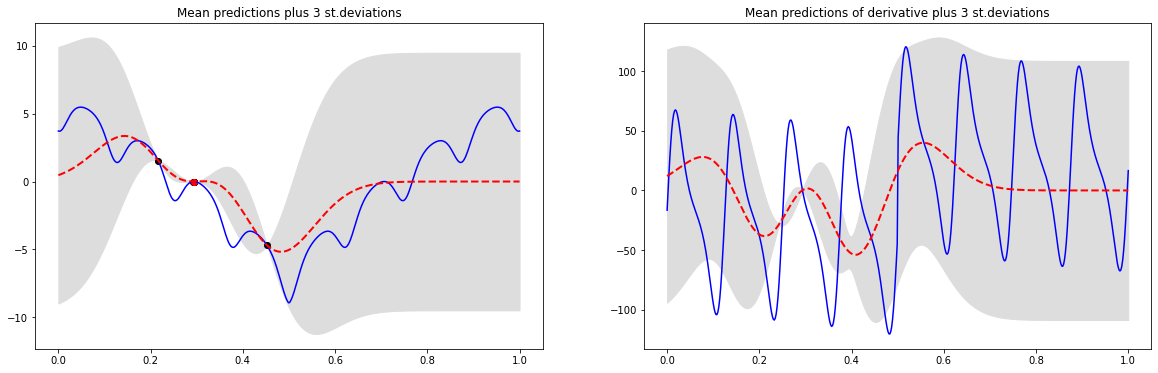

w:  [[0.29341758]]
lr:  [[0.00012294]]
df: [[0.14832087]], s.d. [[0.81293102]]
actual df [0.21078905]


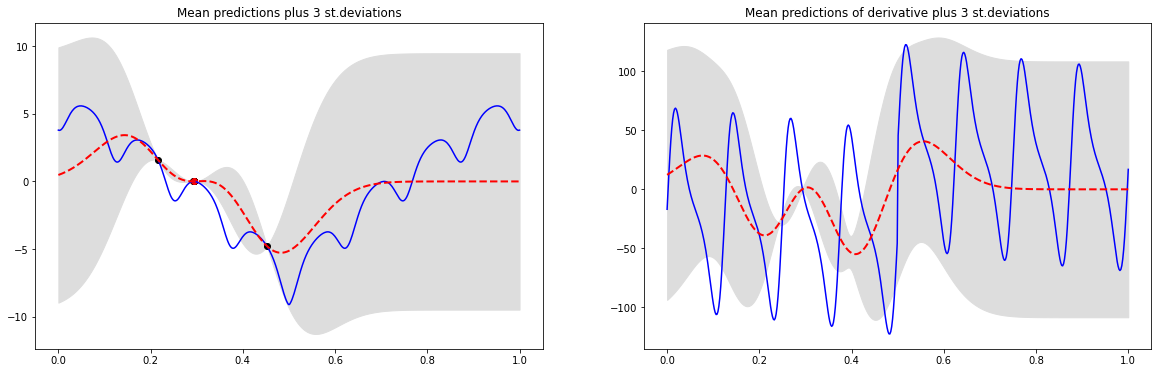

w:  [[0.29340078]]
lr:  [[0.00012823]]
df: [[0.12654413]], s.d. [[0.77954053]]
actual df [0.25077598]


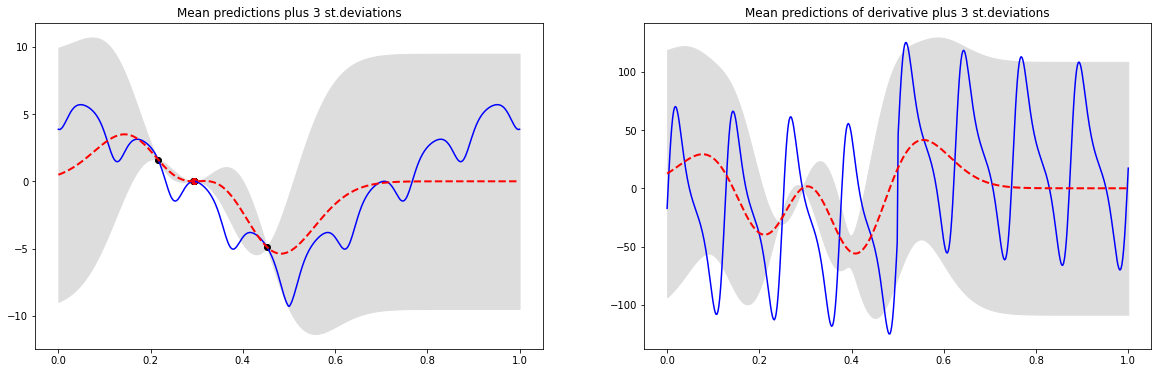

w:  [[0.29338599]]
lr:  [[0.0001338]]
df: [[0.1065741]], s.d. [[0.74723462]]
actual df [0.28774724]


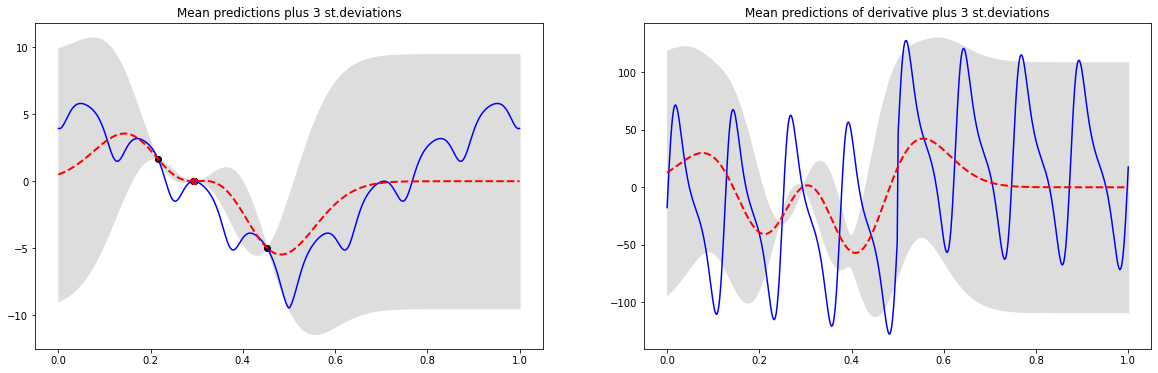

w:  [[0.29337314]]
lr:  [[0.00013957]]
df: [[0.08857259]], s.d. [[0.71646499]]
actual df [0.32156275]


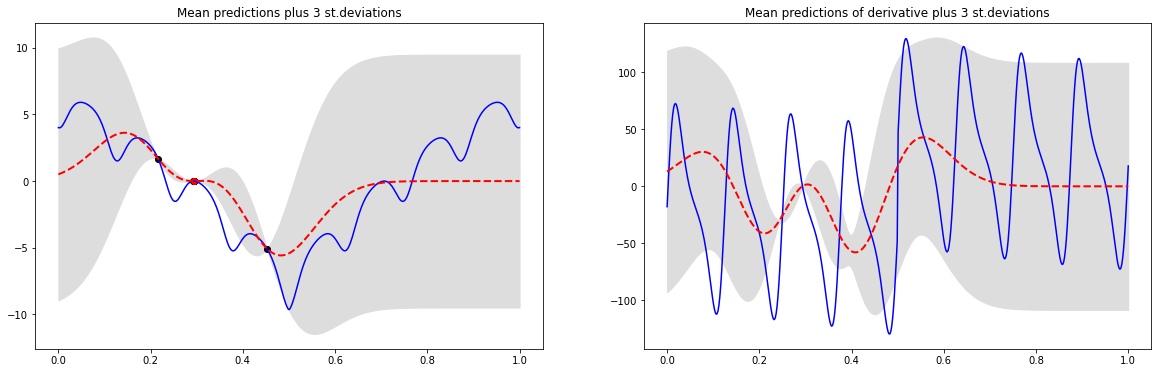

w:  [[0.29336214]]
lr:  [[0.00014545]]
df: [[0.0725664]], s.d. [[0.6875289]]
actual df [0.35215249]
  # Optimal (ls, var) =  (0.07035005304691128, 11.61922482995557)


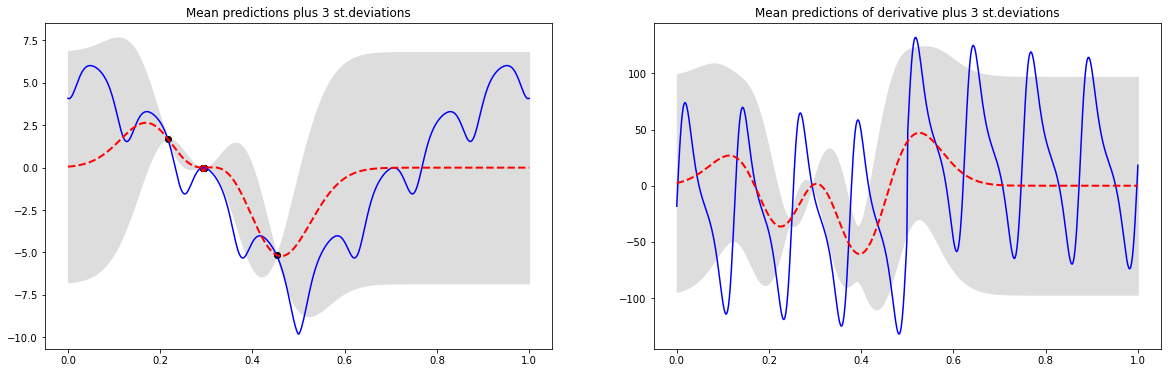

w:  [[0.29335197]]
lr:  [[0.00015089]]
df: [[0.06425281]], s.d. [[0.66318703]]
actual df [0.38162693]


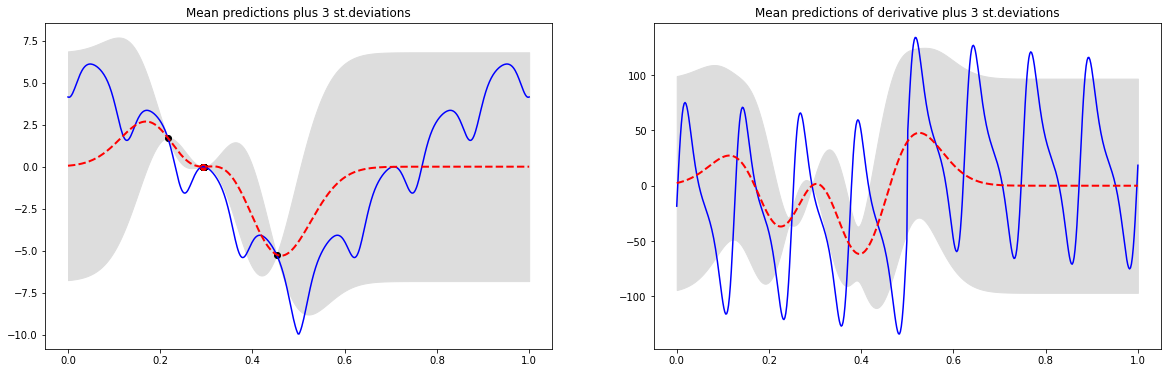

w:  [[0.29334354]]
lr:  [[0.00015668]]
df: [[0.05110077]], s.d. [[0.63869344]]
actual df [0.40771434]


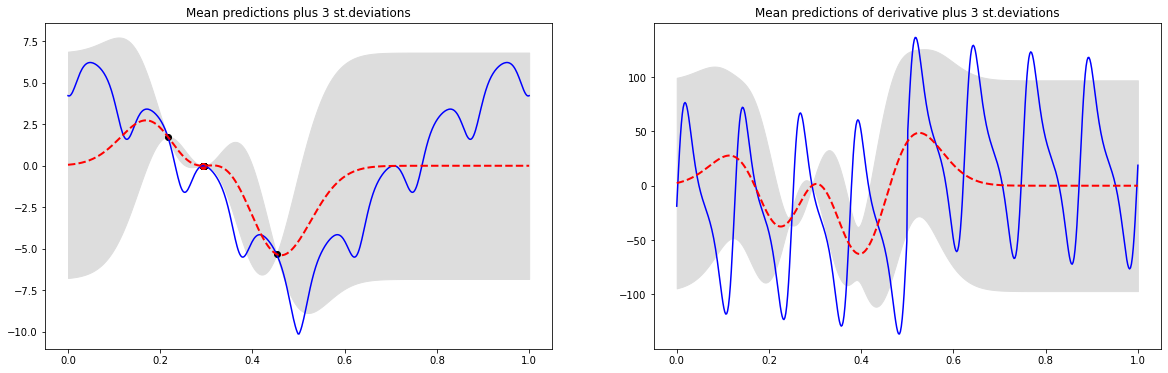

w:  [[0.29333674]]
lr:  [[0.00016243]]
df: [[0.03969547]], s.d. [[0.61609265]]
actual df [0.43049679]


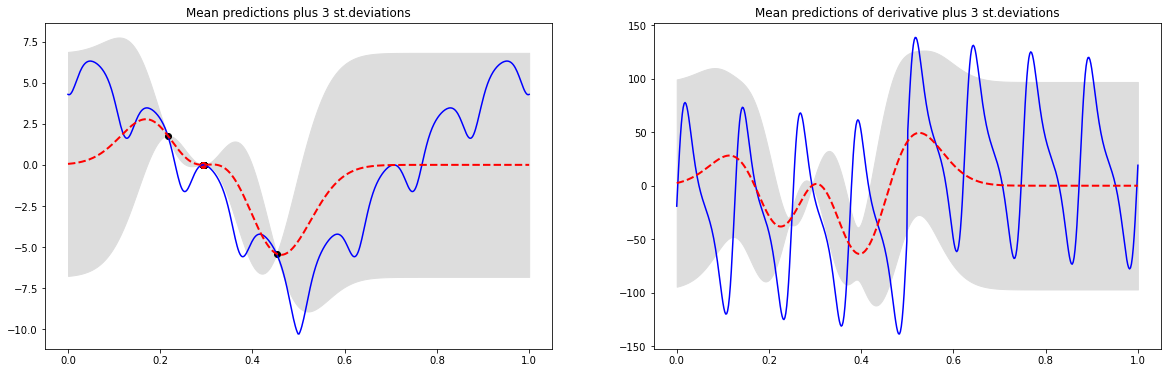

w:  [[0.29333143]]
lr:  [[0.00016807]]
df: [[0.02985739]], s.d. [[0.59535528]]
actual df [0.45009003]


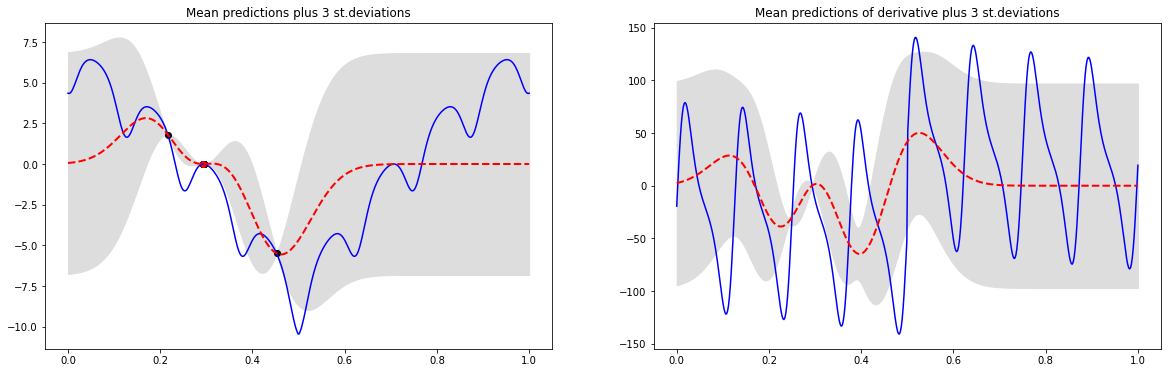

w:  [[0.29332748]]
lr:  [[0.00017358]]
df: [[0.02140097]], s.d. [[0.57641129]]
actual df [0.46662837]
  # Optimal (ls, var) =  (0.07729131052425303, 19.348186889161443)


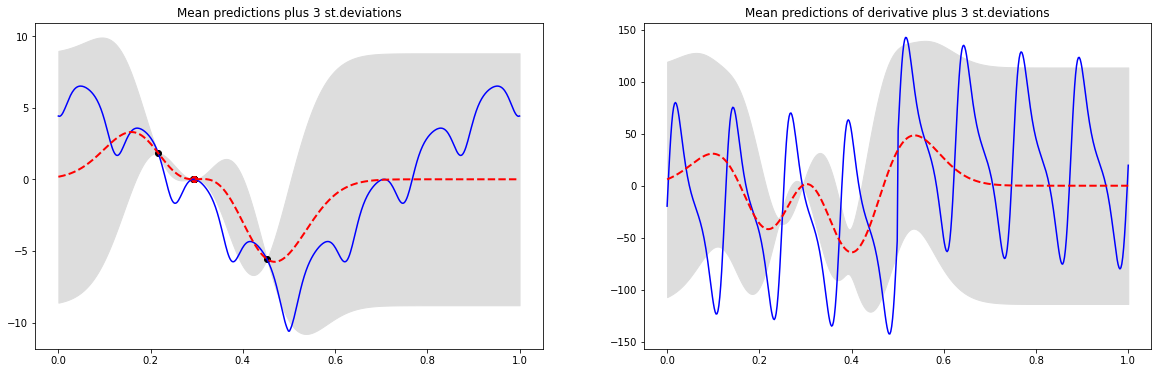

w:  [[0.29332381]]
lr:  [[0.00017919]]
df: [[0.01938858]], s.d. [[0.5583012]]
actual df [0.48268875]


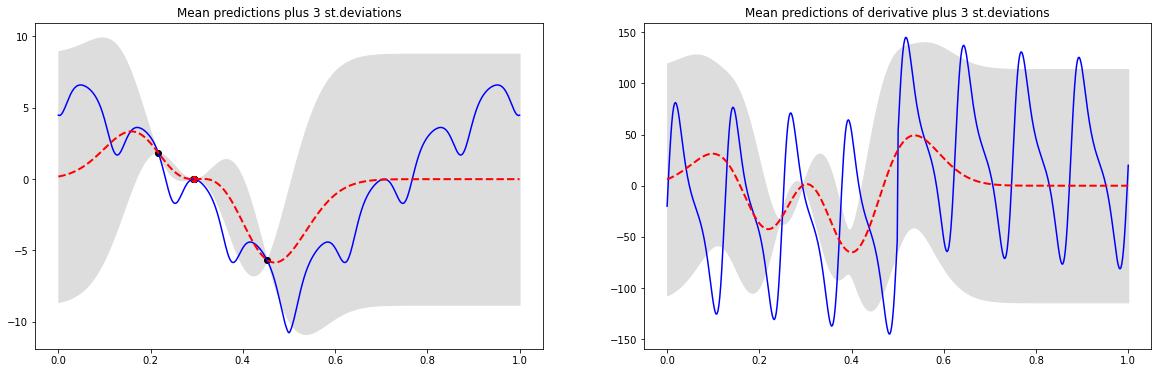

w:  [[0.29332125]]
lr:  [[0.00018438]]
df: [[0.0130552]], s.d. [[0.54254715]]
actual df [0.49608613]


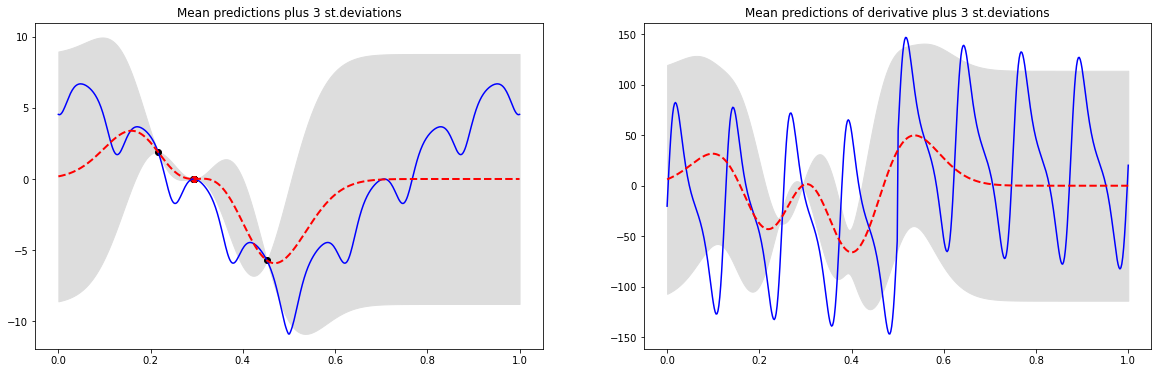

w:  [[0.29331972]]
lr:  [[0.00018937]]
df: [[0.0075992]], s.d. [[0.52818482]]
actual df [0.50695116]


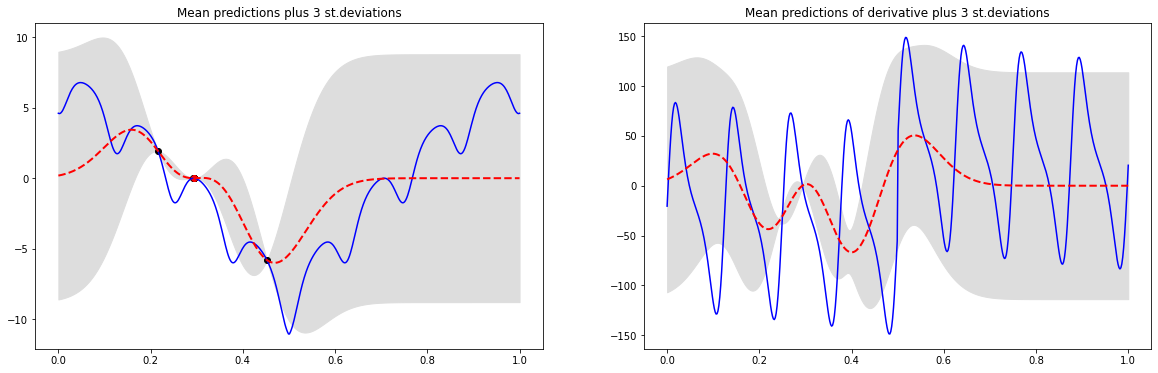

w:  [[0.29331913]]
lr:  [[0.00019415]]
df: [[0.00289443]], s.d. [[0.51511967]]
actual df [0.51541697]


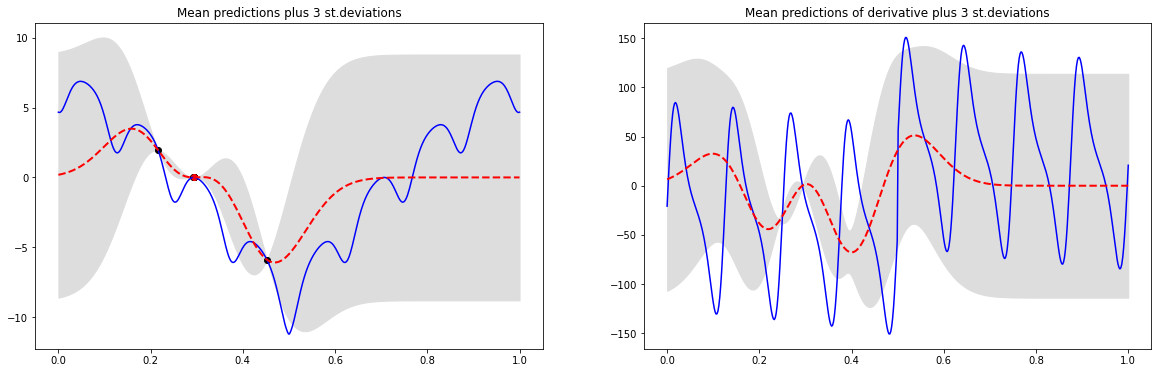

w:  [[0.29331937]]
lr:  [[0.0001987]]
df: [[-0.00116944]], s.d. [[0.50325683]]
actual df [0.52160721]
  # Optimal (ls, var) =  (0.08131226742062954, 27.242670506768498)


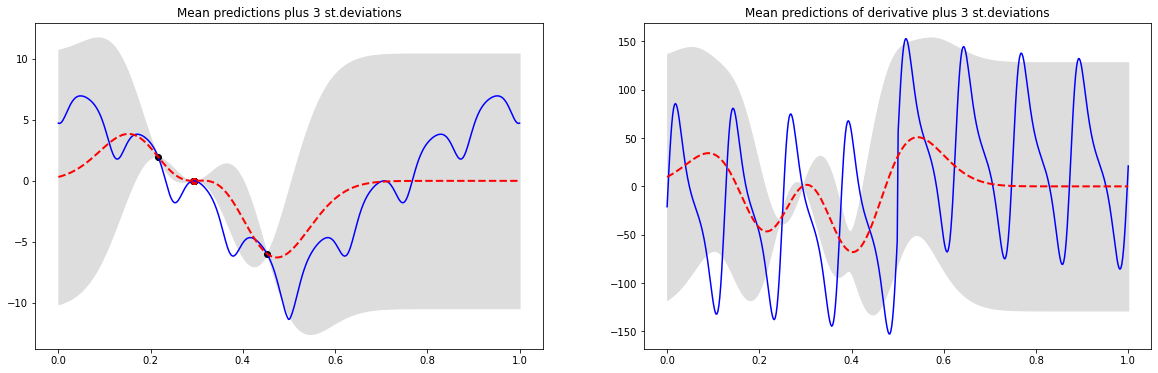

w:  [[0.29331964]]
lr:  [[0.00020305]]
df: [[-0.00123641]], s.d. [[0.49248118]]
actual df [0.527638]


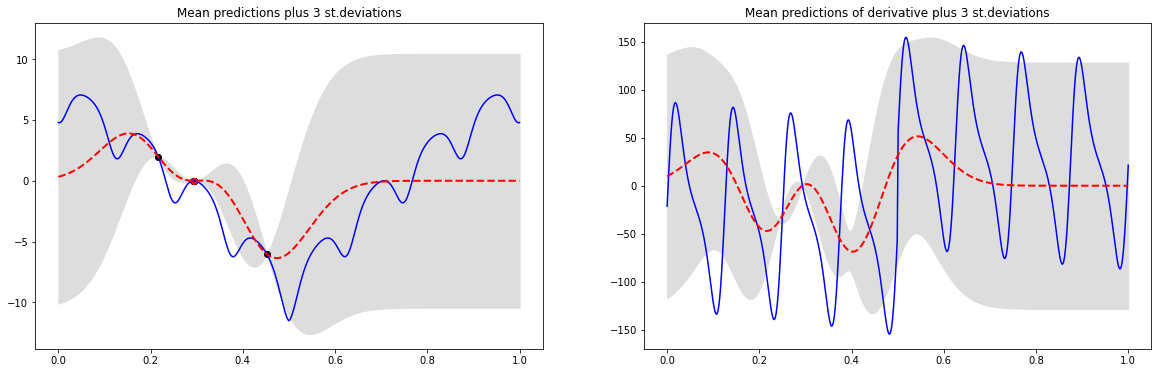

w:  [[0.29332064]]
lr:  [[0.00020712]]
df: [[-0.00448335]], s.d. [[0.482737]]
actual df [0.53161677]


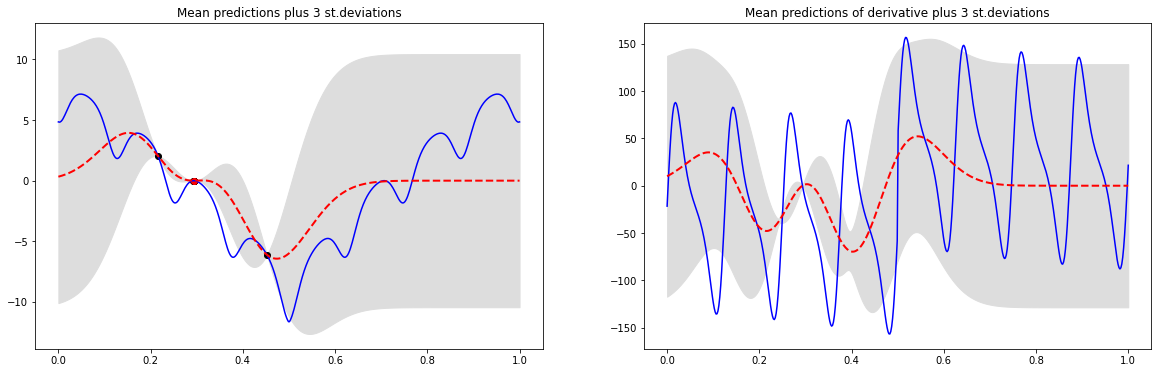

w:  [[0.29332229]]
lr:  [[0.00021097]]
df: [[-0.00731514]], s.d. [[0.47387749]]
actual df [0.53364328]


In [36]:
v = np.array([[0]])
for i in range(1,  n_iter):
    # posterior of GP given gp.X, gp.y
    mu, covar = gp.posterior(Grid)
    s = np.sqrt(np.diag(covar))
    mu = np.squeeze(mu)

    # posterior of GP derivative given gp.X, gp.y
    mu_grad, covar_grad = gp.posterior_grad(Grid)
    s_grad = np.sqrt(np.diag(covar_grad))
    mu_grad = np.squeeze(mu_grad)
    
    # joint MVN
    K = gp.cov_RBF(gp._X, gp._X, gp.get_hyper())
    K_ = gp.cov_RBF(CubeGrid, CubeGrid, gp.get_hyper())
    K_11 = gp.K11(CubeGrid)
    K_01 = gp.K01(CubeGrid)

    fig, (ax1, ax2) = pl.subplots(1, 2, figsize=(20, 6))

    # plot function
    ax1.plot(gp._X, gp._y, 'ko')
    ax1.plot(gp.compress(w), gp._normal(f(w)), 'ro')
    
    ax1.plot(CubeGrid.flat, gp._normal(clean_f(Grid)), 'b-')
    ax1.fill_between(CubeGrid.flat, mu-2*s, mu+2*s, color="#dddddd")

    ax1.plot(CubeGrid, mu, 'r--', lw=2)
#     fig.savefig('predictive.png', bbox_inches='tight')
    ax1.set_title('Mean predictions plus 3 st.deviations')

    # plot derivative
    ax2.plot(CubeGrid.flat, gp._normal_grad(approx_grad), 'b-')
    ax2.fill_between(CubeGrid.flat, mu_grad-2*s_grad, mu_grad+2*s_grad, color="#dddddd")

    ax2.plot(CubeGrid.flat, mu_grad, 'r--', lw=2)
    fig.savefig('predictive_grad.png', bbox_inches='tight')
    ax2.set_title('Mean predictions of derivative plus 3 st.deviations')

    pl.show()  

    # 1. gradient descent
    lr = 1e-3
    m, v = gp.posterior_grad(w)
    lr = np.clip(lr / v, 5e-5, 0.005)
    w = gp._unwrap(np.clip(gp.compress(w) - lr * gp.grad(w), gp._B[:, 0], gp._B[:, 1]))
    
    #     2. nesterov
#     lr = 0.01
#     v = 0.9*v + lr*grad(gp, w-0.9*v)
#     w = np.clip(w - v, lb, ub)
    
    # 3. Adam
    # approximate first and second moment
#     gt = grad(gp, w)
#     mt = b1 * mt + (1 - b1) * gt
#     vt = b2 * vt + (1 - b2) * np.square(gt)

#     # bias corrected moment estimates
#     mhat = mt / (1 - b1 ** i )
#     vhat = vt / (1 - b2 ** i )

#     # update the params
#     delta_w = -1 * lr * mhat/(np.sqrt(vhat) + epsilon)
#     w = w + delta_w
    
    print('w: ', gp.compress(w))
    print('lr: ', lr)
    m, v = gp.posterior_grad(w)
    print('df:', m, end=', ')
    print('s.d.', v)
    print('actual df', gp._normal_grad(optimize.approx_fprime(w[0], lambda x: clean_f(x).item(), eps)) )
#     print('desc:', -gt)
    history.append( f(w) )
    history_lr.append(lr)
    gp.add_data(w, f(w))
    if i % 5 == 1:
        ls, var = gp.optimize()
        print('  # Optimal (ls, var) = ', (ls, var))
    gp.fit()

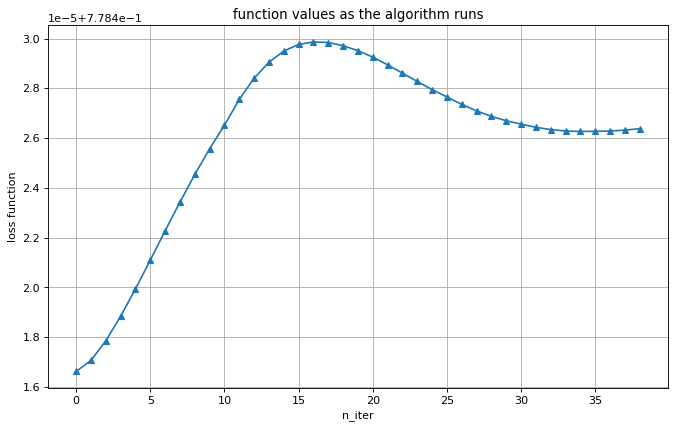

In [37]:
pl.figure(figsize=(10, 6), dpi=80)
pl.plot(np.squeeze(history), "-^")
pl.title("function values as the algorithm runs")
pl.xlabel("n_iter")
pl.ylabel("loss function")
pl.grid(True)

In [21]:
# plot lr
# pl.figure(figsize=(10, 6), dpi=80)
# pl.plot(history_lr, "-^")
# pl.title("learning rate as the algorithm runs")
# pl.xlabel("n_iter")
# pl.ylabel("learning rate")
# pl.yscale("log")
# pl.grid(True)

### Thompson Sampling

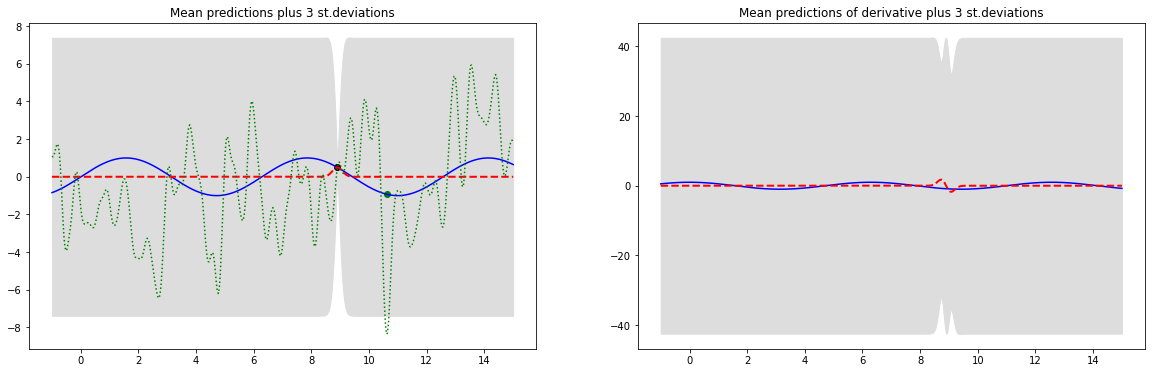

w:  [10.60721443]


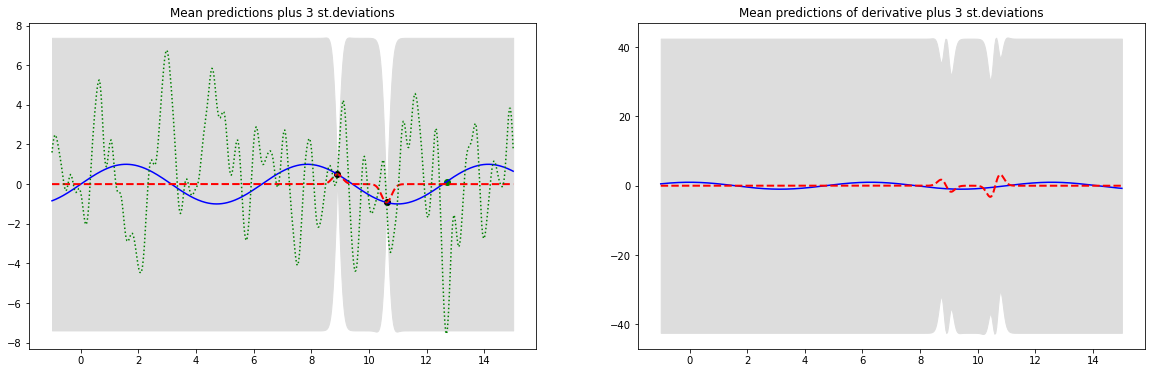

w:  [12.69138277]


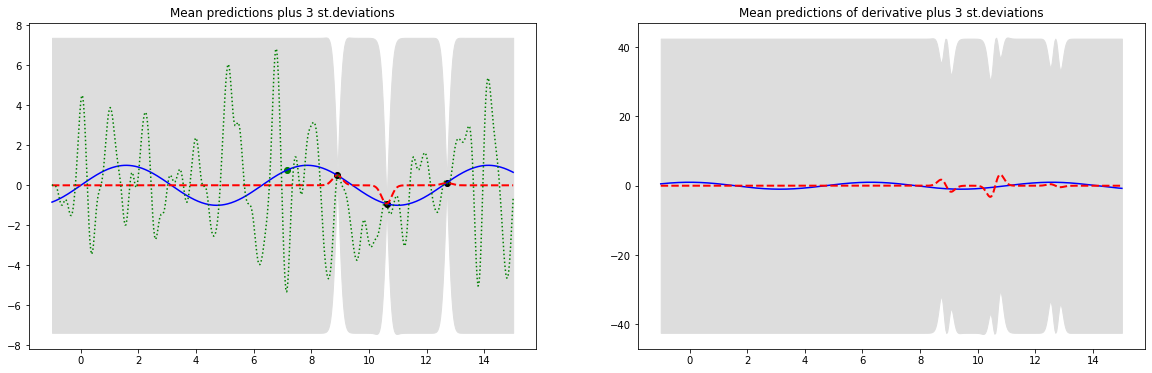

w:  [7.14428858]


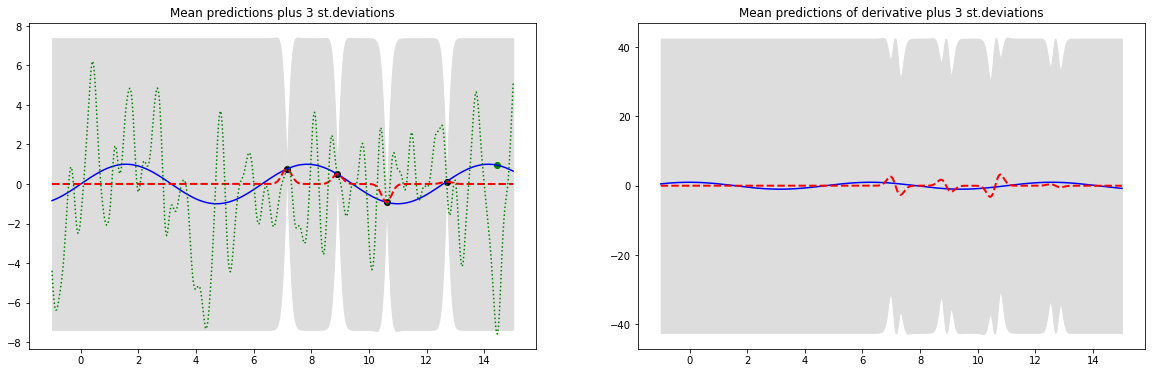

w:  [14.45490982]


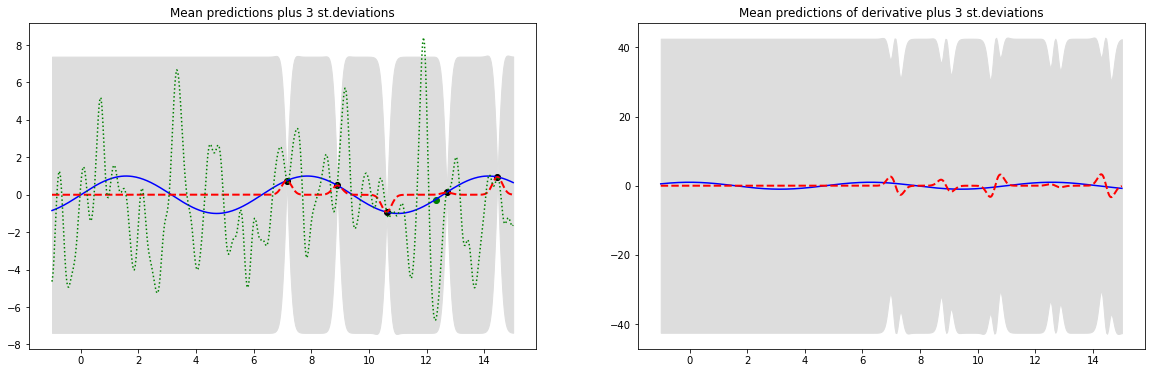

w:  [12.30661323]


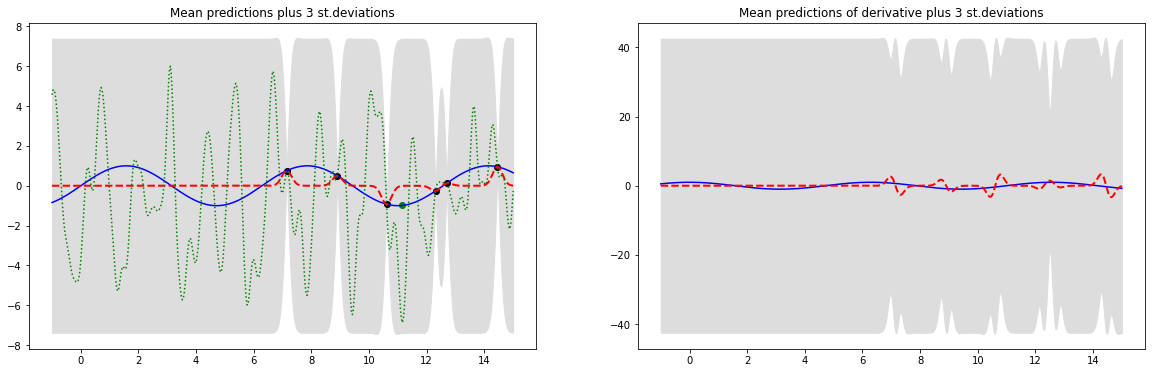

w:  [11.15230461]


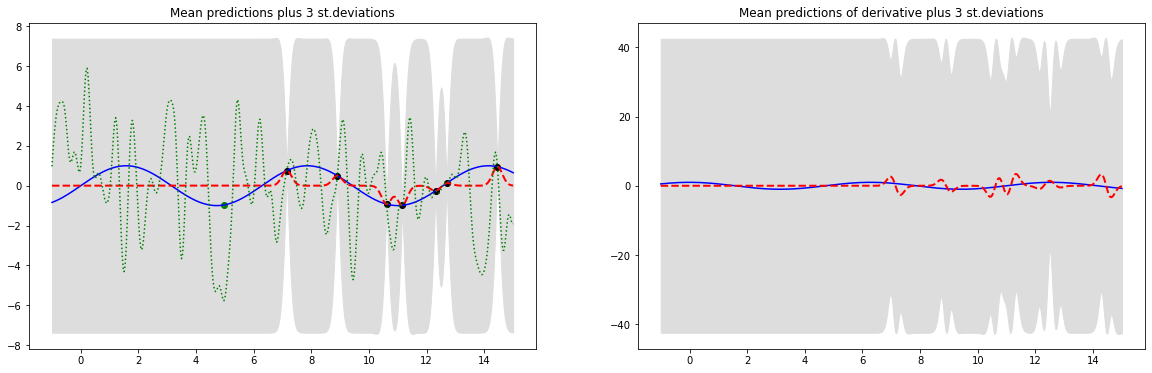

w:  [4.96392786]


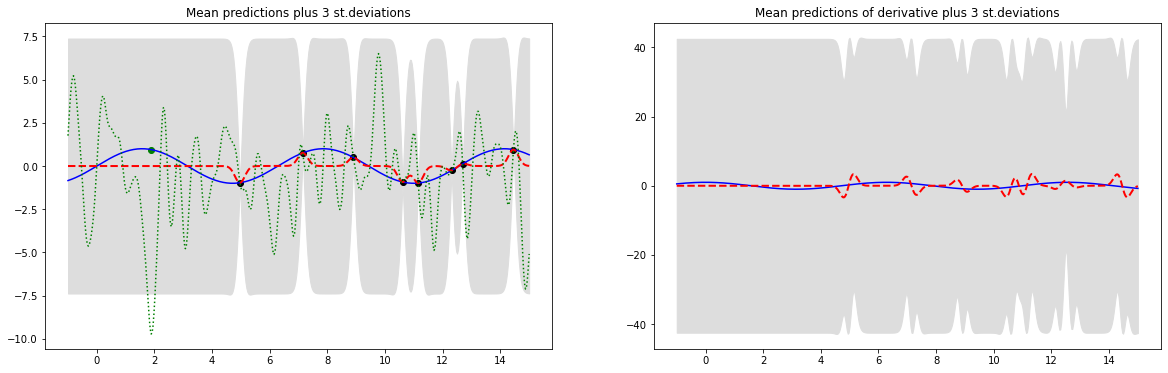

w:  [1.88577154]


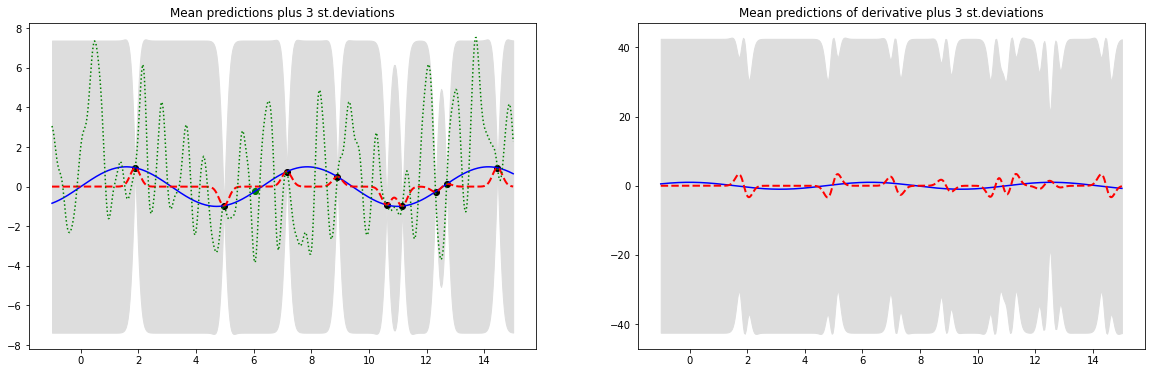

w:  [6.05410822]


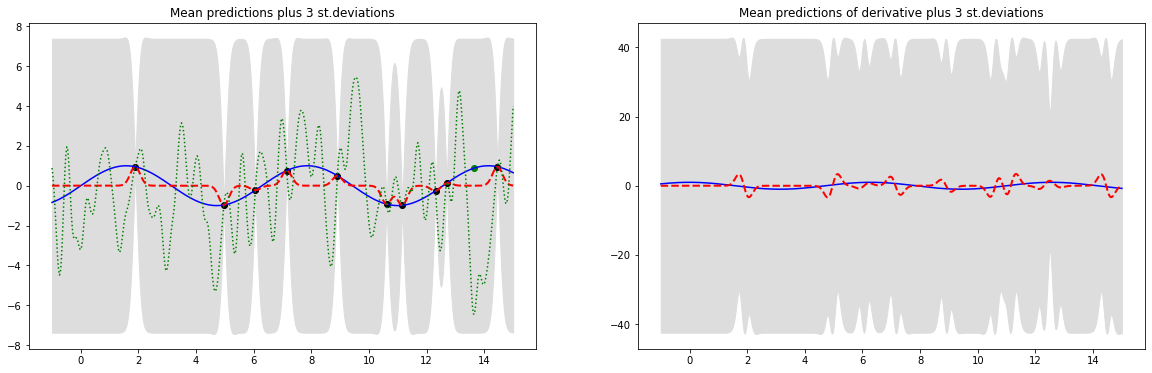

w:  [13.65330661]


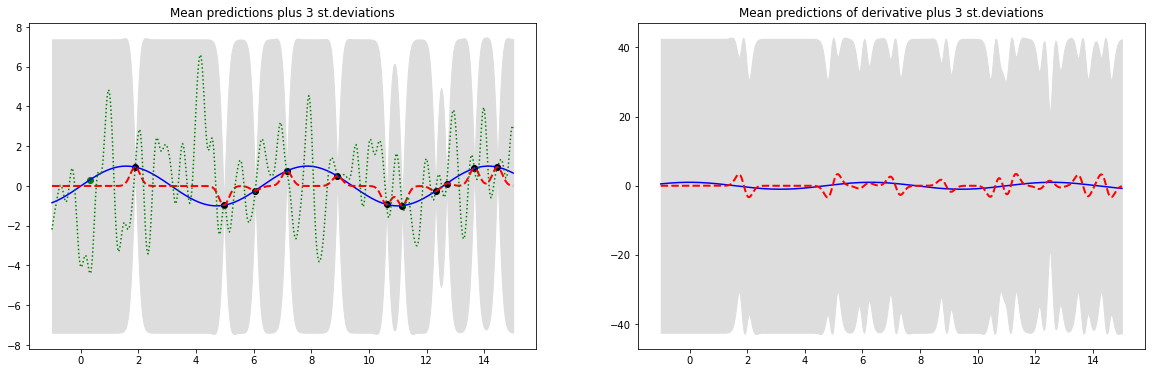

w:  [0.31462926]


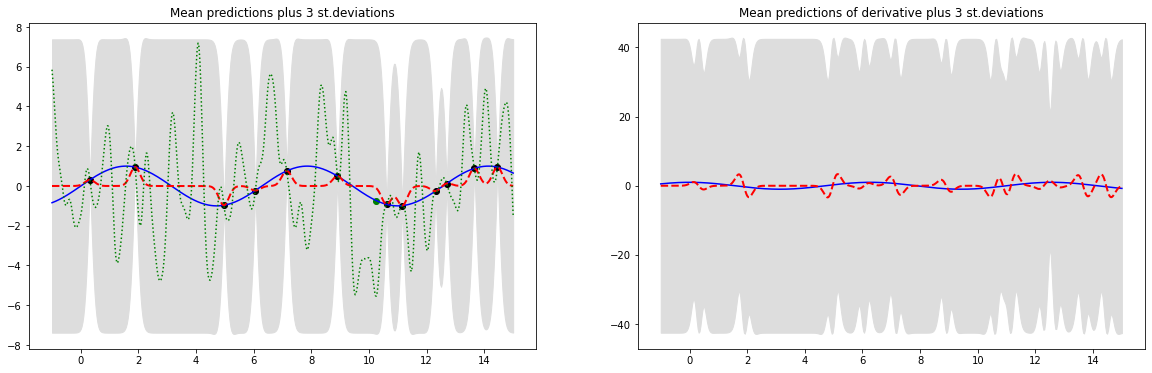

w:  [10.25450902]


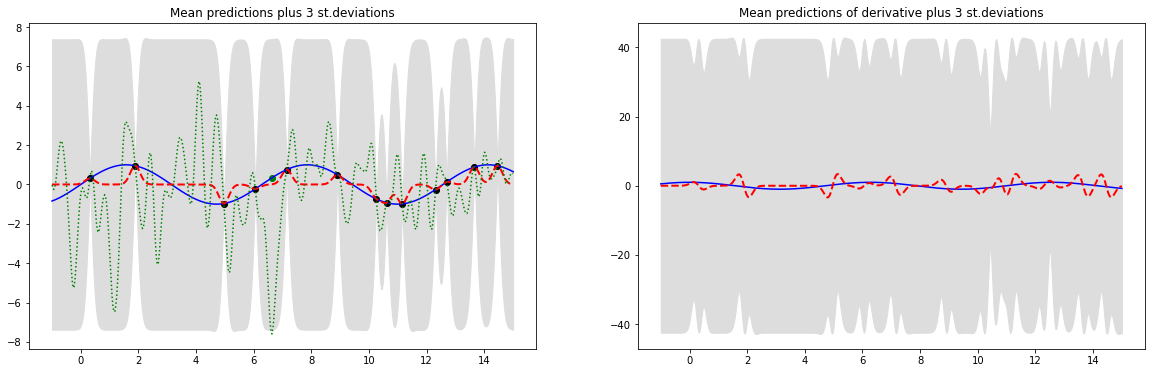

w:  [6.63126253]


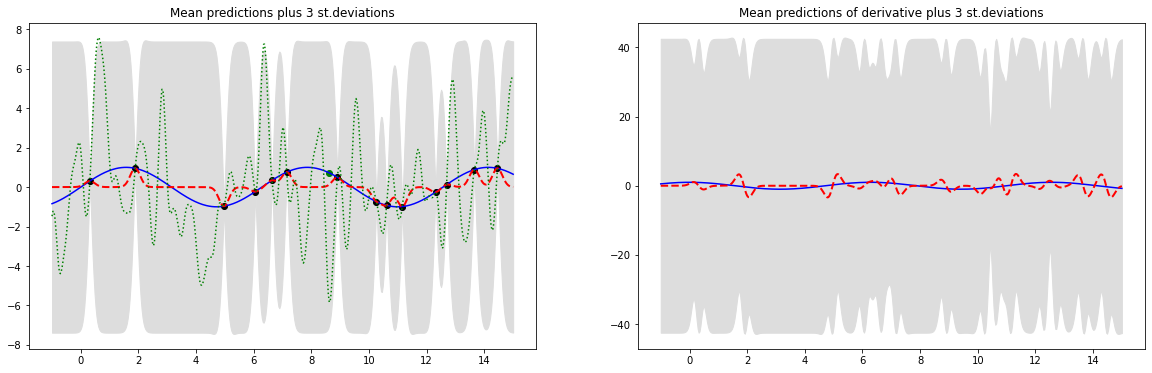

w:  [8.61923848]


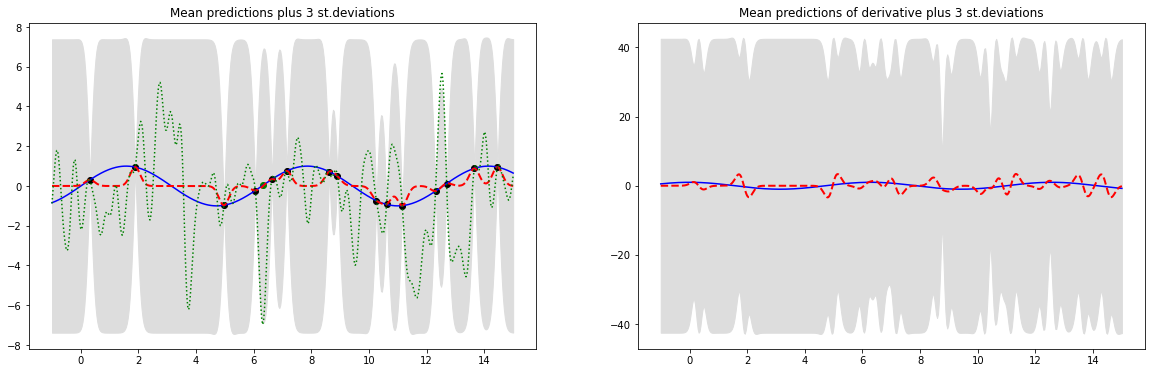

w:  [6.31062124]


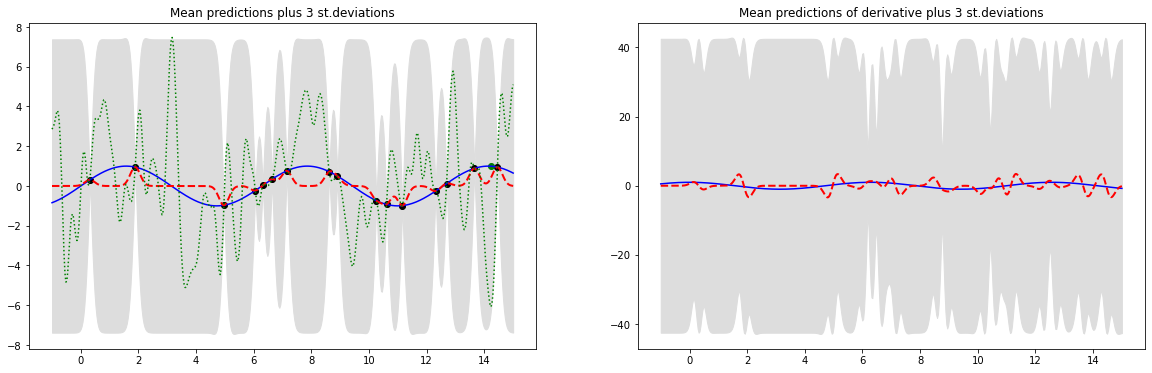

w:  [14.23046092]


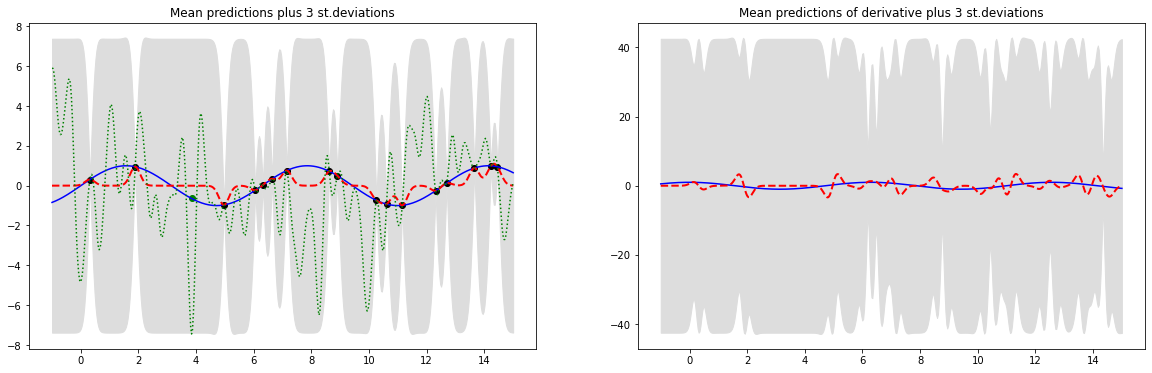

w:  [3.84168337]


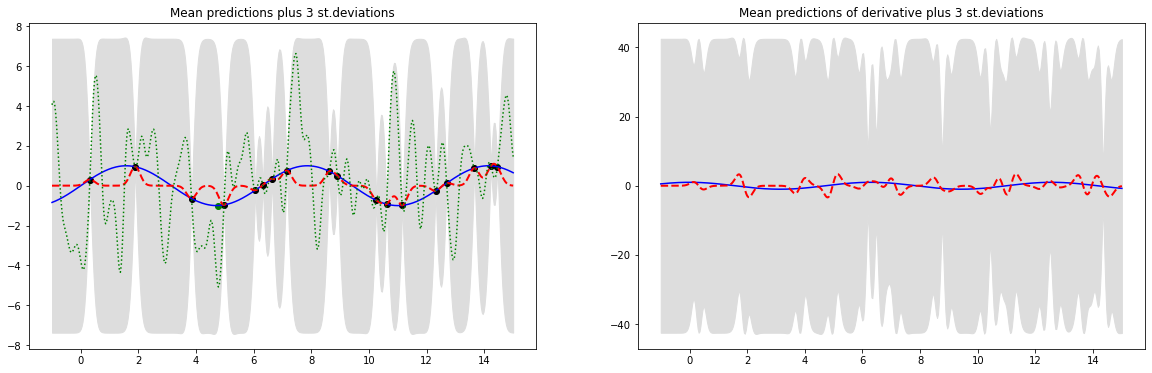

w:  [4.77154309]


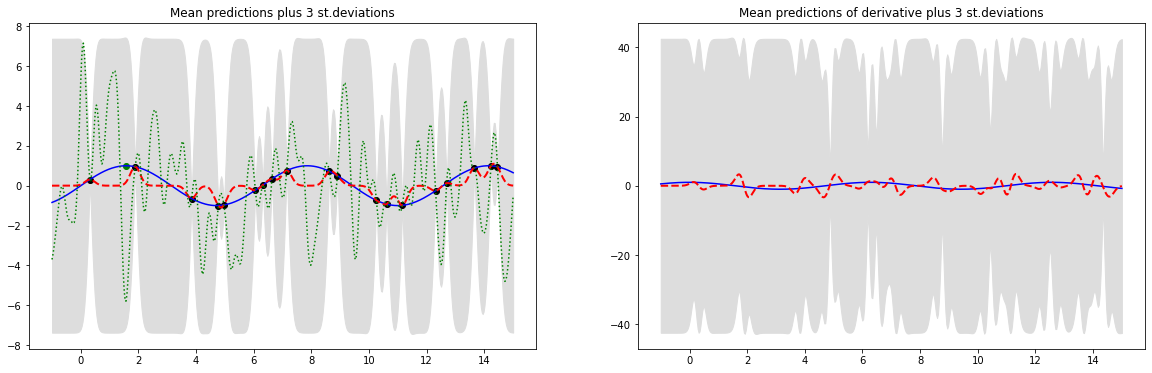

w:  [1.56513026]


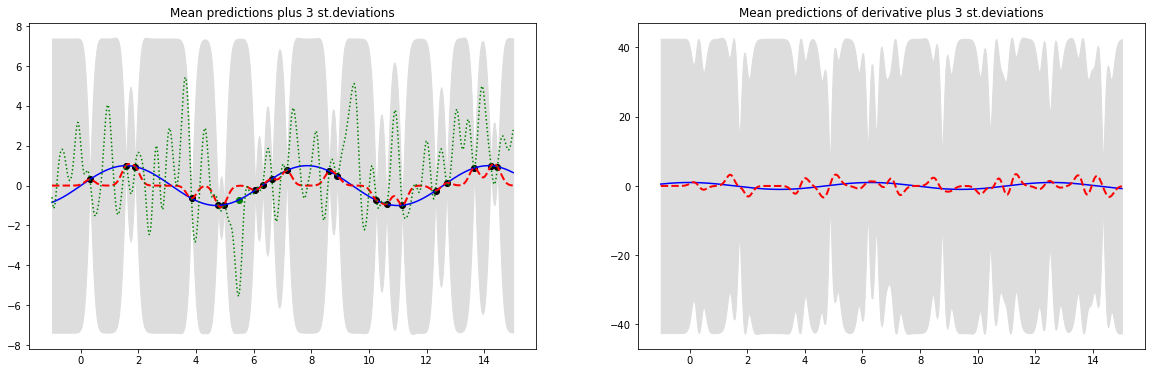

w:  [5.47695391]


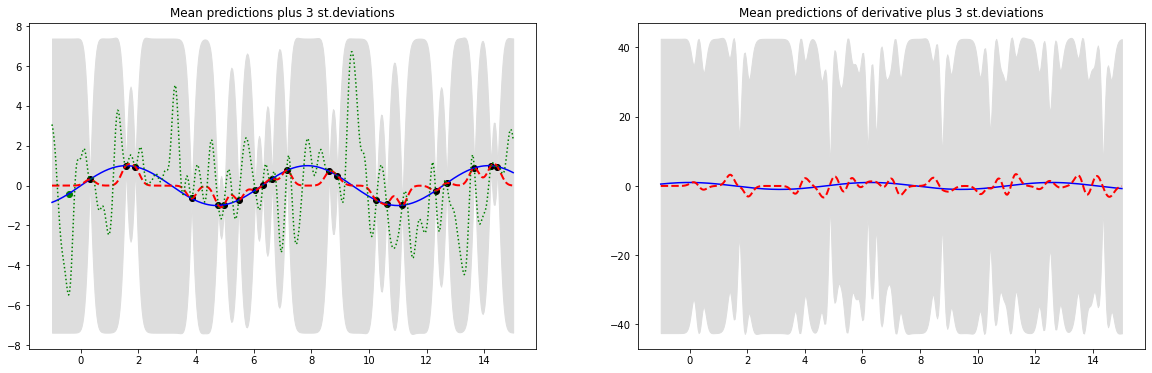

w:  [-0.42284569]


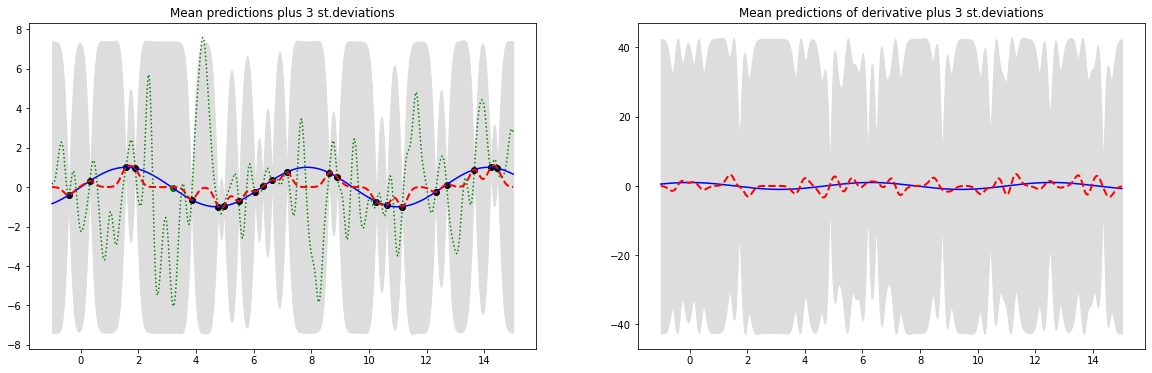

w:  [3.2004008]


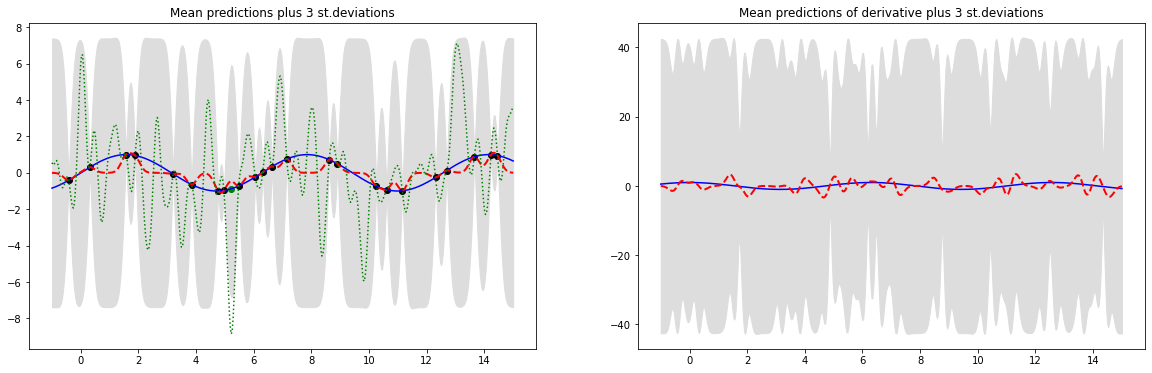

w:  [5.22044088]


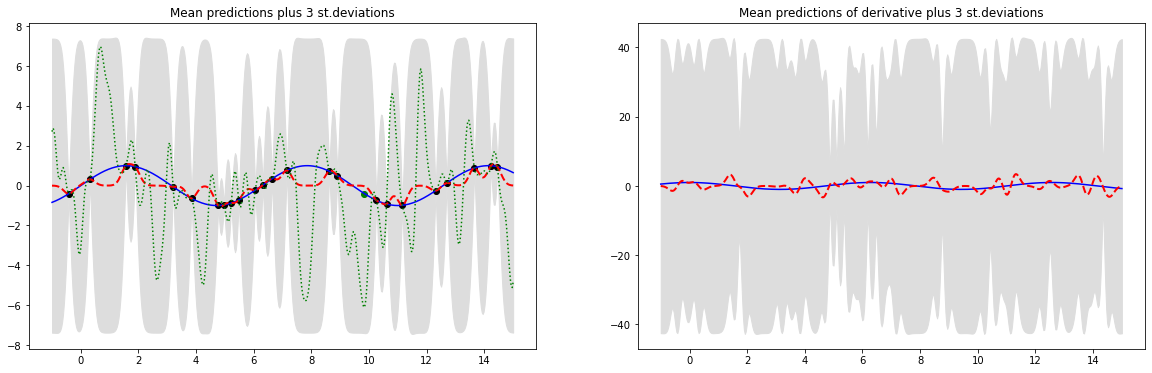

w:  [9.83767535]


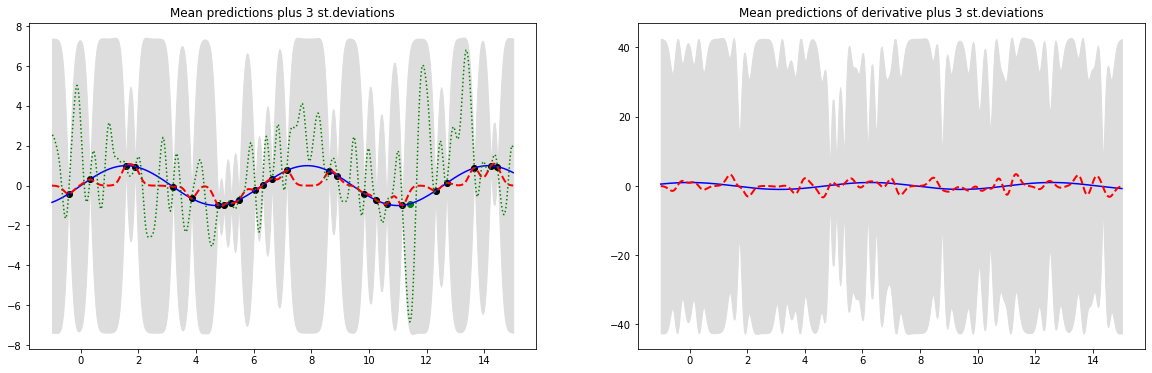

w:  [11.40881764]


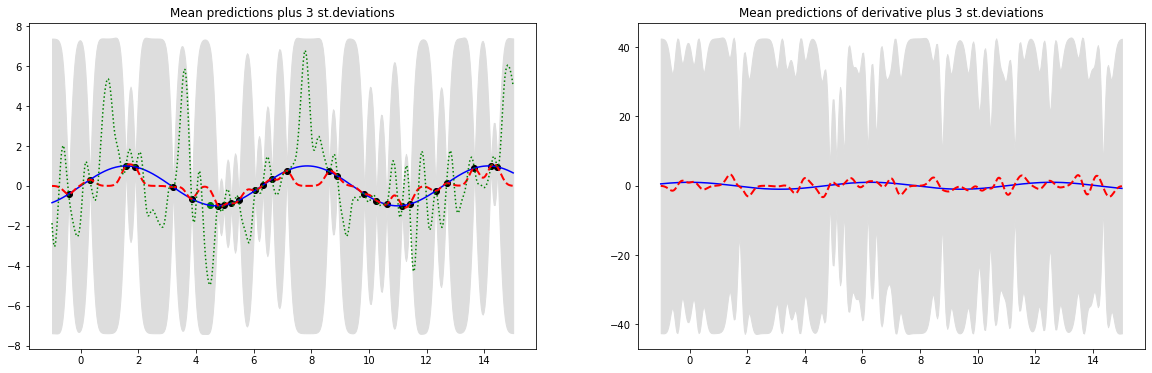

w:  [4.48296593]


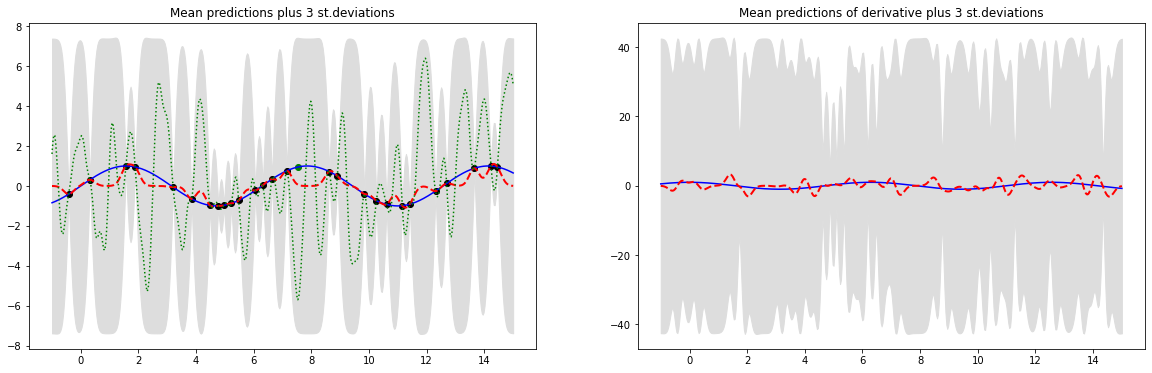

w:  [7.52905812]


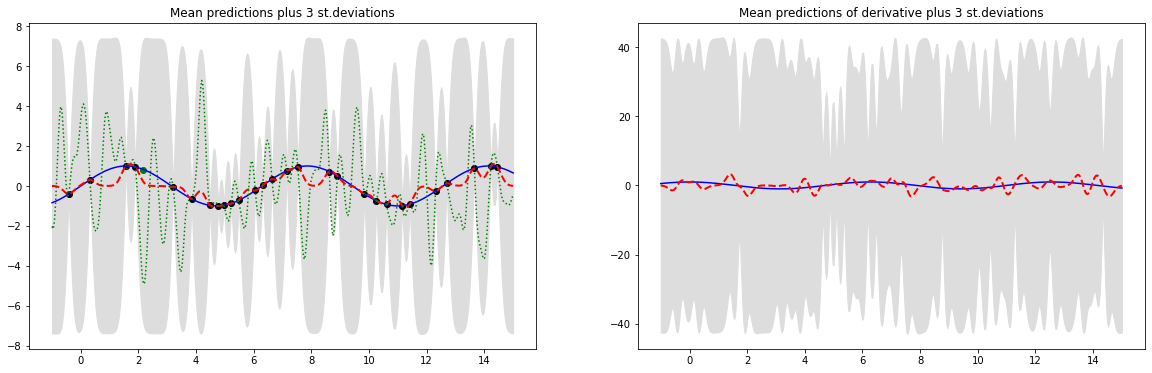

w:  [2.1743487]


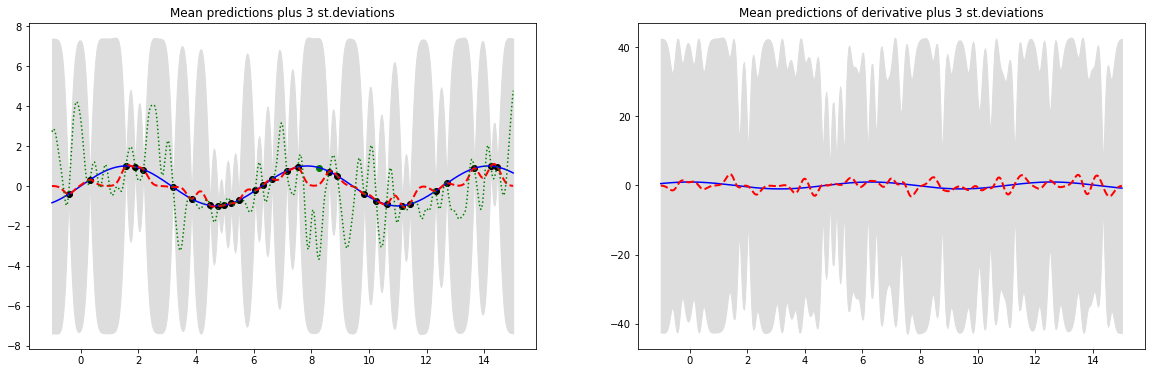

w:  [8.26653307]


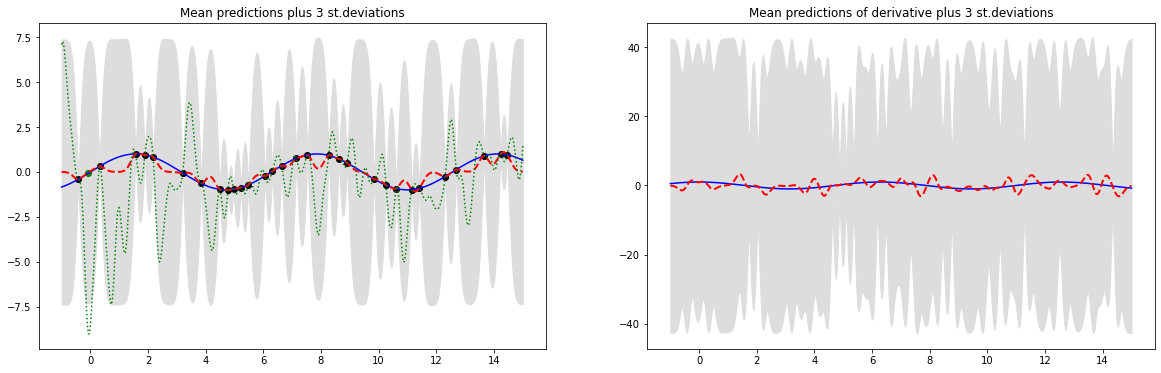

w:  [-0.07014028]


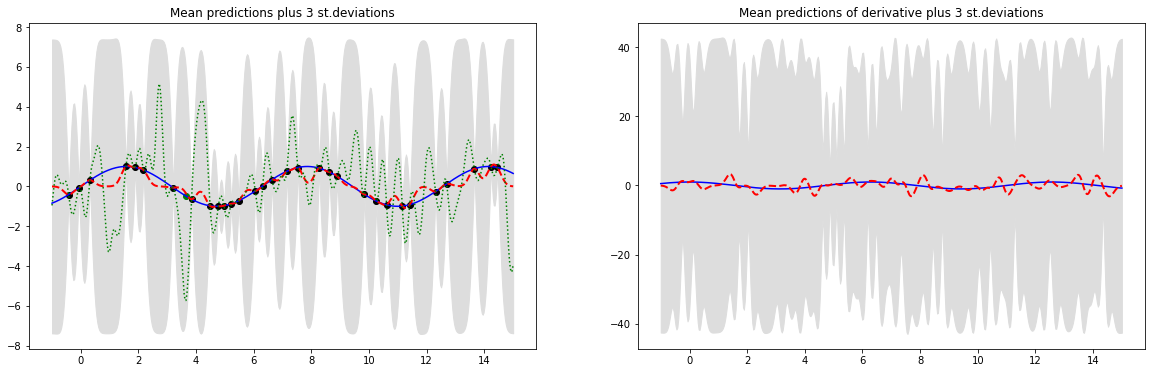

w:  [3.6492986]


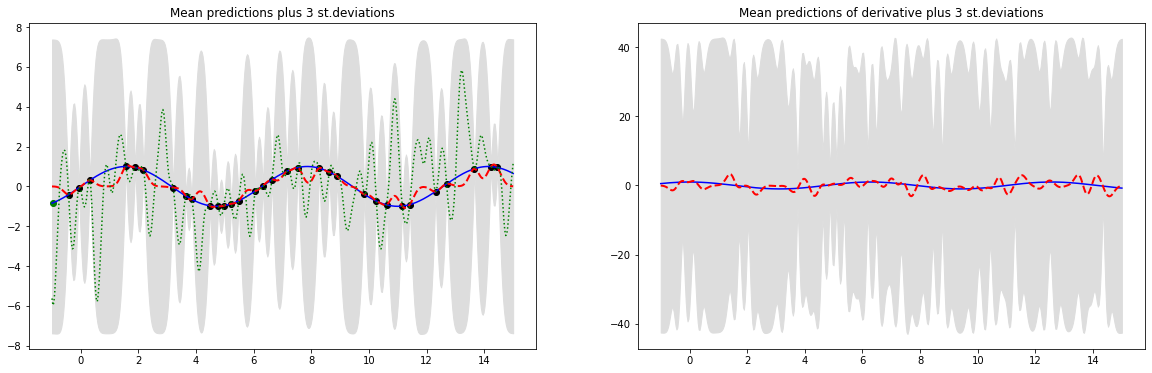

w:  [-0.96793587]


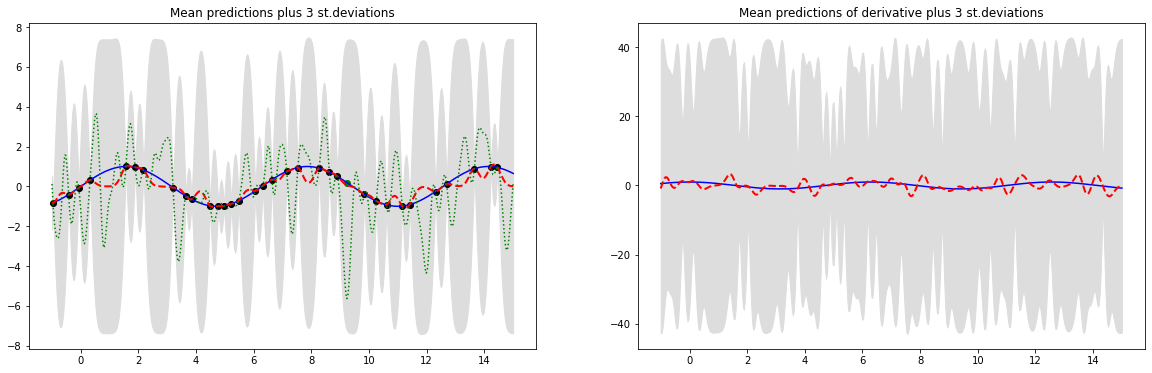

w:  [9.22845691]


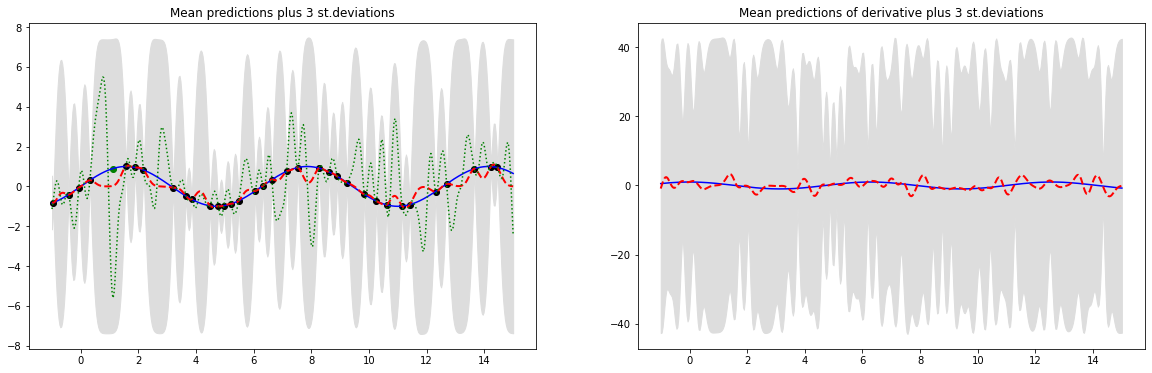

w:  [1.11623246]


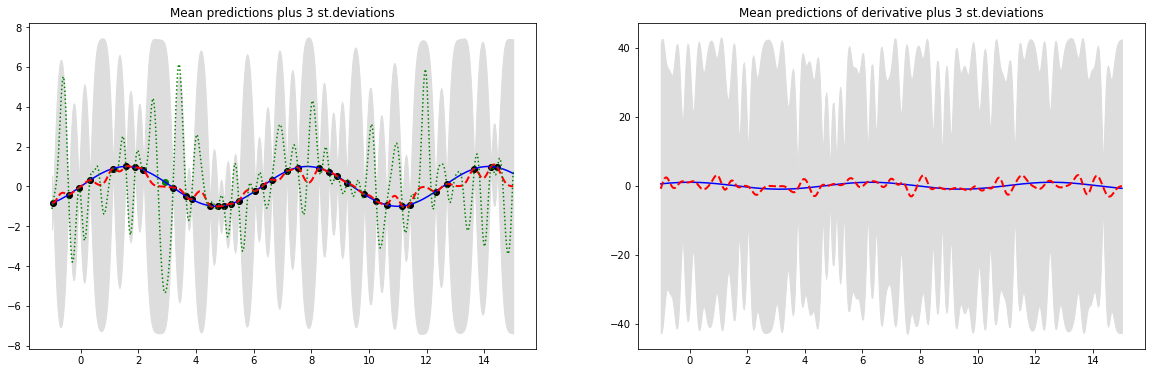

w:  [2.91182365]


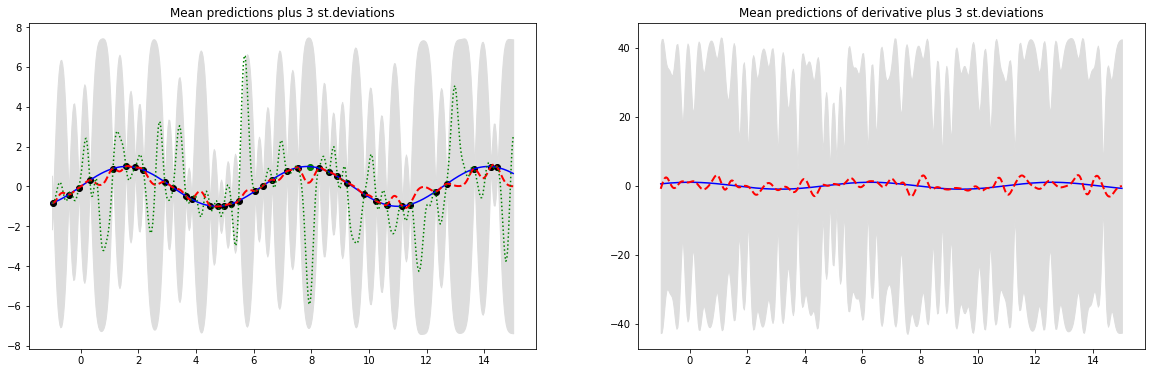

w:  [7.94589178]


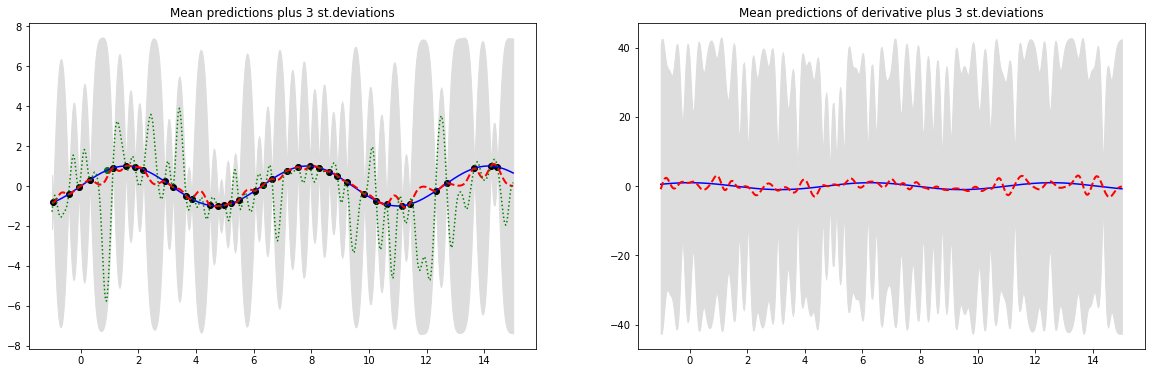

w:  [0.89178357]


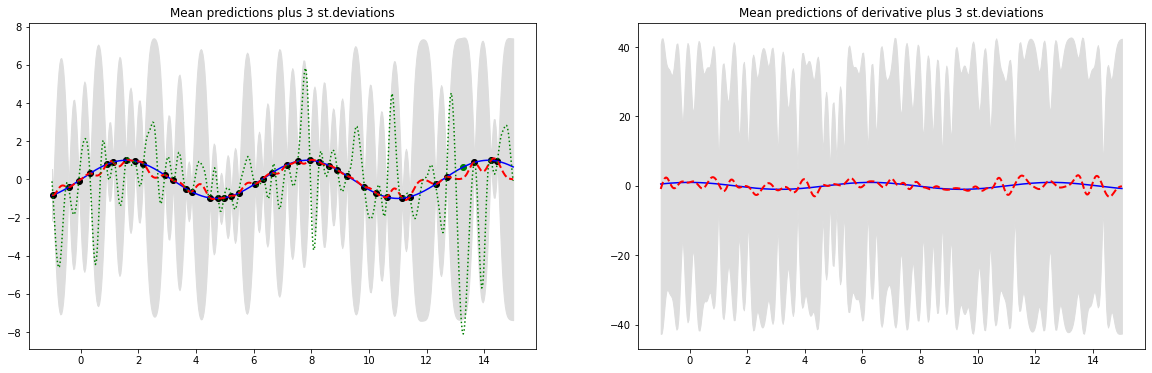

w:  [13.26853707]


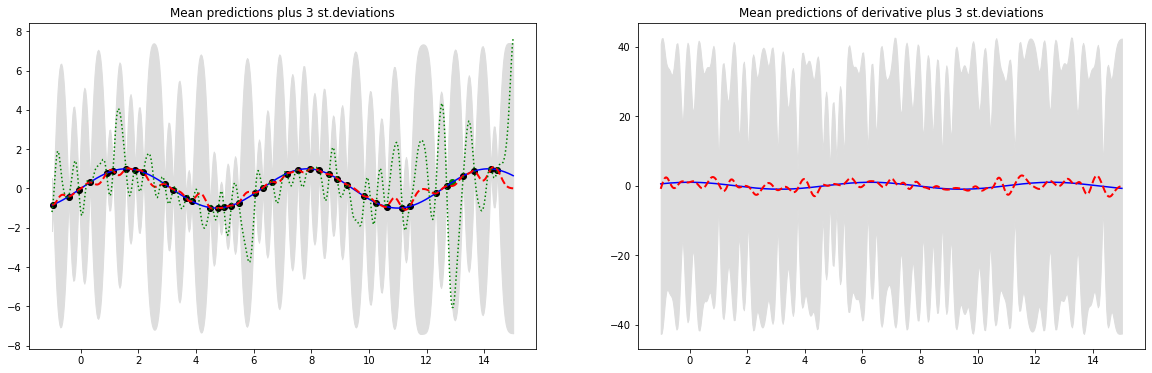

w:  [12.88376754]


In [25]:
gp.clear()
gp.set_hyper(ls, var)
gp.set_data(X, f(X))
gp.fit()

n_iter = 40
history = []

w = X[0].reshape(-1, 1)

for i in range(1,  n_iter):
    # posterior of GP given gp.X, gp.y
    mu, covar = gp.posterior(Grid)
    mu = np.squeeze(mu)
    s = np.sqrt(np.diag(covar))

    # posterior of GP derivative given gp.X, gp.y
    mu_grad, covar_grad = gp.posterior_grad(Grid)
    mu_grad = np.squeeze(mu_grad)
    s_grad = np.sqrt(np.diag(covar_grad))
    
    # joint MVN
    K = gp.cov_RBF(gp.X, gp.X, gp.get_hyper())
    K_ = gp.cov_RBF(Grid, Grid, gp.get_hyper())
    K_11 = gp.K11(Grid)
    K_01 = gp.K01(Grid)
    
    L = np.linalg.cholesky(covar + 1e-6*np.eye(n_Grid)) # LL^T = Sigma (posterior covariance)
    f_post = mu.reshape(-1,1) + np.dot(L, np.random.normal(size=(n_Grid, dim)))
    arg_min = np.argmin(f_post)
    w = Grid[arg_min]
    
    fig, (ax1, ax2) = pl.subplots(1, 2, figsize=(20, 6))

    # plot function
    ax1.plot(np.squeeze(gp.X), np.squeeze(gp.y), 'ko')
    ax1.plot(np.squeeze(w), np.squeeze(f(w)), 'go')
    
    ax1.plot(Grid.flat, np.sin(Grid.flat), 'b-')
#     ax1.plot(Grid.flat, functions.Ackley_1().func(Grid), 'b-')
    ax1.fill_between(Grid.flat, mu-2.576*s, mu+2.576*s, color="#dddddd")
    ax1.plot(Grid, mu, 'r--', lw=2)
    ax1.plot(Grid.flat, f_post, 'g:')
    ax1.set_title('Mean predictions plus 3 st.deviations')
#     ax1.axis([-5, 15, -3, 3])


    # plot derivative
    # pl.plot(X, y, 'r+', ms=7)
#     ax2.plot(Grid.flat, np.cos(Grid.flat) + 0.1, 'b-') 
    ax2.fill_between(Grid.flat, mu_grad-2.576*s_grad, mu_grad+2.576*s_grad, color="#dddddd")
    ax2.plot(Grid.flat, approx_grad, 'b-')
    ax2.plot(Grid.flat, mu_grad, 'r--', lw=2)
    ax2.set_title('Mean predictions of derivative plus 3 st.deviations')
#     ax2.axis([-5, 15, -3, 3])
    
#     filename = 'Ackley_' + str(i) + '_noise_TS' +'.png'
#     pl.savefig('Result_Plots/' + filename)
    pl.show()  
    
    print('w: ', w)
    history.append( f(w) )
    gp.add_data(w, f(w))
    gp.fit()

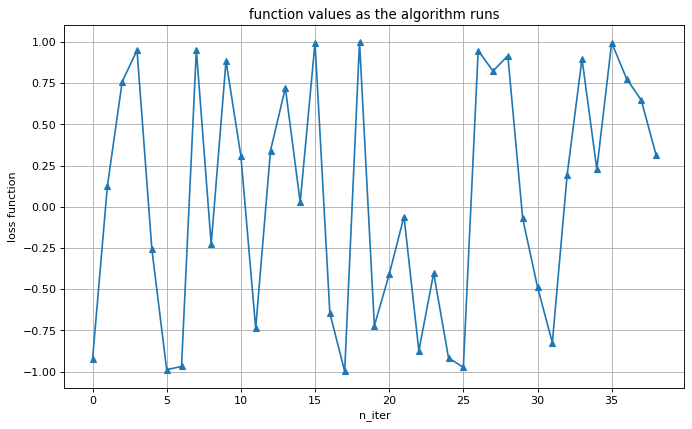

In [26]:
pl.figure(figsize=(10, 6), dpi=80)
pl.plot(np.squeeze(history), "-^")
pl.title("function values as the algorithm runs")
pl.xlabel("n_iter")
pl.ylabel("loss function")
pl.grid(True)

In [ ]:
# # Creates the .gif from the saved plots for the 2D_Plots dir.
# filenames = []
# for i in range(1, n_iter):
#     filename = 'Ackley_' + str(i) + '_noise_TS' +'.png'
#     filenames.append(filename)

# frames=[]
# for filename in filenames:
#     frames.append(imageio.imread('Result_Plots/' + filename))
# exportname = 'Ackley_noise.gif'

# kargs = { 'duration': 0.5 }
# imageio.mimsave(exportname, frames, 'GIF', **kargs)